In [1]:
# Load Libraries
import pandas as pd
import numpy as np

### Load Data

In [2]:
# Load data to a DataFrame
beanDF = pd.read_excel('DryBeanDataset/Dry_Bean_Dataset.xlsx')

In [3]:
# Look at the shape of the DataFrame
beanDF.shape

(13611, 17)

In [4]:
# See the relative numbers of each target category
beanDF.value_counts('Class')

Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
dtype: int64

### Feature Selection

#### Lowest Variance

Features with low variance will have less information. Note that features should be scaled prior to comparing variance.

In [5]:
# Load libraries
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold

# Create features and target
features = beanDF.select_dtypes(include='number')
target = beanDF.Class

# Create scaler
minmax_scale = MinMaxScaler(feature_range=(0,1))

# Scale features
scaled_features = minmax_scale.fit_transform(features)

# Create thresholder
thresholder = VarianceThreshold()

# Create high-variance feature matrix
features_high_variance = thresholder.fit_transform(scaled_features)

# Look at features, sorted by variance (highest to lowest)
d = {'Column': features.columns, 'Variance': thresholder.fit(scaled_features).variances_}
varianceDF = pd.DataFrame(d).sort_values('Variance', ascending=False)
varianceDF

,Column,Variance
13,ShapeFactor2,0.036926
11,Compactness,0.031678
4,AspectRation,0.030804
14,ShapeFactor3,0.030760
8,Extent,0.024929
2,MajorAxisLength,0.023817
12,ShapeFactor1,0.021609
1,Perimeter,0.021522
7,EquivDiameter,0.021022
3,MinorAxisLength,0.017733


In [6]:
# Make a list of columns with variance less than 10e-2
low_var = varianceDF['Column'][(varianceDF['Variance'] < 1.6e-2)].tolist()

# Features to drop
print("Features with low variance:\n", low_var)

Features with low variance:
 ['Area', 'ConvexArea', 'roundness', 'ShapeFactor4', 'Solidity']


#### Least Informative

In [7]:
## USE ANOVA F-VALUE TO FIND THE MOST INFORMATIVE FEATURES

# Load libraries
# from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import SelectPercentile

# Create features and target
features = beanDF.select_dtypes(include='number')
target = beanDF.Class

# Select the n features with the highest F-values
fvalue_selector = SelectKBest(f_classif, k=11)
features_kbest = fvalue_selector.fit_transform(features, target)

# # Select top 75% of features with highest F-values
# fvalue_selector = SelectPercentile(f_classif, percentile=75)
# features_kbest = fvalue_selector.fit_transform(features, target)

# Look at first row of best features
features_kbest[0]

array([2.83950000e+04, 6.10291000e+02, 2.08178117e+02, 1.73888747e+02,
       1.19719142e+00, 2.87150000e+04, 1.90141097e+02, 9.13357755e-01,
       7.33150614e-03, 3.14728917e-03, 8.34222388e-01])

In [8]:
# Make a list of the low information features
low_inf = features.columns[~features.iloc[0].isin(features_kbest[0])].tolist()

# Features to drop
print("Features with low information:\n", low_inf)

Features with low information:
 ['Eccentricity', 'Extent', 'Solidity', 'roundness', 'ShapeFactor4']


#### Recursively Eliminate Features Using Cross-Validation

In [9]:
# Load libraries
import warnings
from sklearn.datasets import make_regression
from sklearn.feature_selection import RFECV
from sklearn import datasets, linear_model

In [10]:
## ENCODE CATEGORICAL TARGET COLUMN

# Load libraries
from sklearn.preprocessing import OrdinalEncoder

# Set up encoder
ord_enc = OrdinalEncoder()

# Encode categorical target variable 'Class'
class_encoded = ord_enc.fit_transform(beanDF[['Class']])

In [11]:
# Create features and target
features = beanDF.select_dtypes(include='number')
target = class_encoded

# Create a linear regression
ols = linear_model.LinearRegression()

# Recursively eliminate features
rfecv = RFECV(estimator=ols, step=1, scoring="neg_mean_squared_error")
rfecv.fit(features, target)
rfecv.transform(features)

array([[0.00314729],
       [0.00356362],
       [0.00304773],
       ...,
       [0.00188827],
       [0.00185203],
       [0.00163981]])

In [12]:
# Number of best features
rfecv.n_features_

1

In [13]:
# Rank features best (1) to worst
rfecv.ranking_

array([15, 13, 14, 11,  6,  8, 16, 12, 10,  5,  7,  3,  2,  1,  4,  9])

In [14]:
# Rank features best to worst (from RFECV)
d = {'Features': features.columns, 'Rank': rfecv.ranking_}
ranked = pd.DataFrame(d).sort_values('Rank')
ranked

,Features,Rank
13,ShapeFactor2,1
12,ShapeFactor1,2
11,Compactness,3
14,ShapeFactor3,4
9,Solidity,5
4,AspectRation,6
10,roundness,7
5,Eccentricity,8
15,ShapeFactor4,9
8,Extent,10


In [15]:
ranked.Features[-4:].tolist()

['Perimeter', 'MajorAxisLength', 'Area', 'ConvexArea']

In [16]:
# Make a list of the least useful features after cross-validation
low_rank = ranked.Features[-5:].tolist()

# Features to drop
print("Features ranked poorly using RFECV:\n", low_rank)

Features ranked poorly using RFECV:
 ['EquivDiameter', 'Perimeter', 'MajorAxisLength', 'Area', 'ConvexArea']


#### Features to drop

In [17]:
# Combine lists of features to drop
all_drop = low_var + low_inf + low_rank

# Look at how many times each feature shows up
for feat in set(all_drop):
    print(f"{feat}: {all_drop.count(feat)}")

ConvexArea: 2
Extent: 1
Area: 2
Solidity: 2
EquivDiameter: 1
roundness: 2
ShapeFactor4: 2
MajorAxisLength: 1
Eccentricity: 1
Perimeter: 1


In [18]:
# Generate a list of features to drop
to_drop = list(set(all_drop))

In [19]:
# subsetDF = beanDF.copy()

In [20]:
# Drop features
subsetDF = beanDF.drop(columns=to_drop)
subsetDF.columns

Index(['MinorAxisLength', 'AspectRation', 'Compactness', 'ShapeFactor1',
       'ShapeFactor2', 'ShapeFactor3', 'Class'],
      dtype='object')

#### Highly Correlated

In [21]:
## LOOK AT HIGHLY CORRELATED FEATURES
# (i.e. likely to be redundant)

# Create features and target
features = subsetDF.select_dtypes(include='number')
target = subsetDF.Class

# Create correlation matrix
corr_matrix = features.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                 k=1).astype(np.bool))

# Find index of feature columns with high correlation
hi_corr = [column for column in upper.columns if any(upper[column] > 0.99)]

# Features to drop
print("Features with high correlation:\n", hi_corr)

Features with high correlation:
 ['ShapeFactor3']


I reordered the DataFrame based on the ranking from the previous REFCV step and then re-ran this correlation step to make sure I wasn't inadvertently removing the more important feature and I got the same result, so I will proceed to remove this feature.

In [22]:
# Drop feature
subsetDF.drop(columns=hi_corr, inplace=True)
subsetDF.columns

Index(['MinorAxisLength', 'AspectRation', 'Compactness', 'ShapeFactor1',
       'ShapeFactor2', 'Class'],
      dtype='object')

In [23]:
subsetDF.head()

,MinorAxisLength,AspectRation,Compactness,ShapeFactor1,ShapeFactor2,Class
0,173.888747,1.197191,0.913358,0.007332,0.003147,SEKER
1,182.734419,1.097356,0.953861,0.006979,0.003564,SEKER
2,175.931143,1.209713,0.908774,0.007244,0.003048,SEKER
3,182.516516,1.153638,0.928329,0.007017,0.003215,SEKER
4,190.279279,1.060798,0.970516,0.006697,0.003665,SEKER


### Histograms

In [24]:
# Load libraries
import matplotlib.pyplot as plt

In [25]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 4)

In [26]:
def makeHistogram(var, df=beanDF):
    # Create a histogram from a DataFrame variable
    plt.hist(df[var], bins=40)
    plt.xlabel(var, fontsize=20)
    plt.ylabel('Counts', fontsize=20)
    plt.tick_params(axis='both', labelsize=15)
    plt.show()

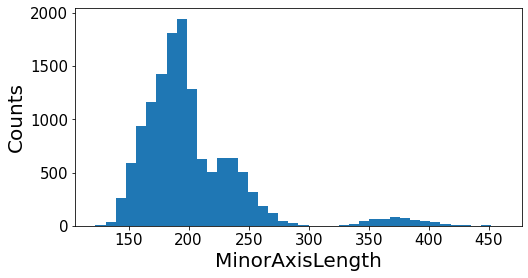

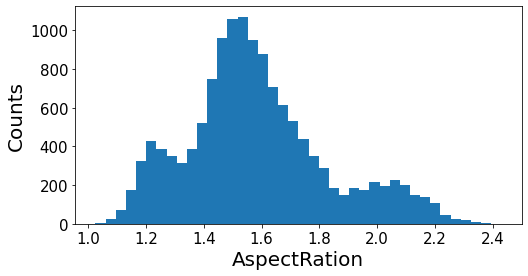

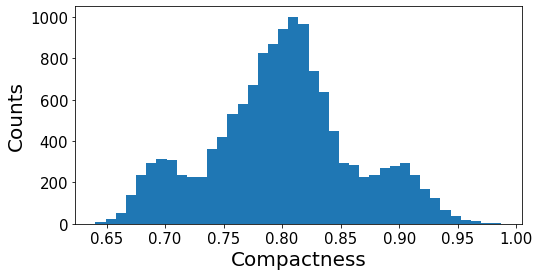

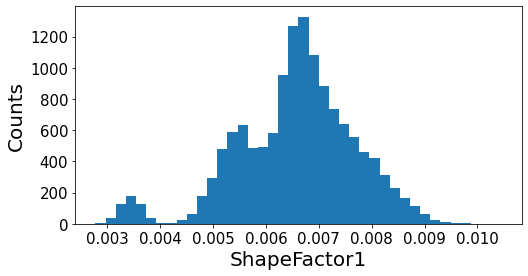

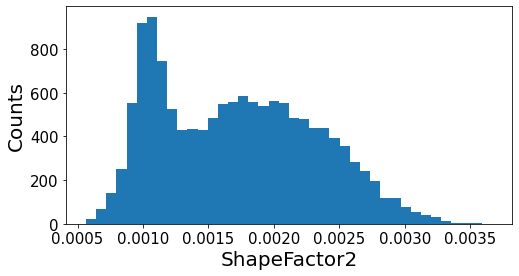

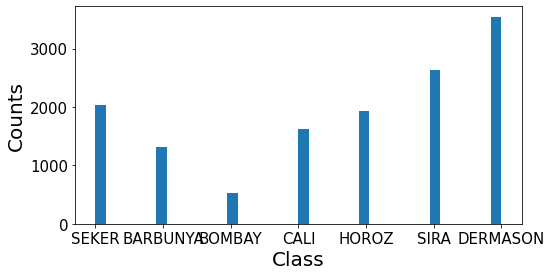

In [27]:
# Iterate through columns to get a quick look
# at the distribution of each variable
for item in subsetDF.columns:
    makeHistogram(item)

### Transformations

In [28]:
# Create a new DataFrame for data transformations
transformDF = subsetDF.copy()

In [29]:
transformDF.skew()

MinorAxisLength    2.238211
AspectRation       0.582573
Compactness        0.037115
ShapeFactor1      -0.534141
ShapeFactor2       0.301226
dtype: float64

#### Right Skew: Log(10)

In [30]:
# Features with large right skew (> 1)
transformDF.skew()[transformDF.skew() > 1]

MinorAxisLength    2.238211
dtype: float64

In [31]:
# Get a list of the columns for log-transformation
pos_skew = transformDF.skew()[transformDF.skew() > 1].index.tolist()
pos_skew

['MinorAxisLength']

In [32]:
# Apply a log10-tranformation to right-skewed columns
for item in pos_skew:
    transformDF[item] = np.log10(transformDF[item])

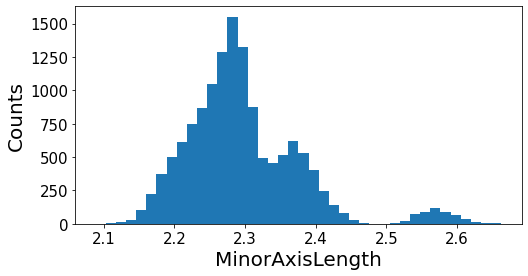

In [33]:
makeHistogram('MinorAxisLength', df=transformDF)

#### Left Skew: Cube

In [34]:
# Features with large left skew (< -1)
transformDF.skew()[transformDF.skew() < -1]

Series([], dtype: float64)

In [35]:
# Get a list of the columns for cube tranformation
neg_skew = transformDF.skew()[transformDF.skew() < -1].index.tolist()
neg_skew

[]

In [36]:
# Apply a cube-tranformation to left-skewed columns
for item in neg_skew:
    transformDF[item] = transformDF[item]**3

No Features with a large left skew to transform.

In [37]:
transformDF.head()

,MinorAxisLength,AspectRation,Compactness,ShapeFactor1,ShapeFactor2,Class
0,2.240271,1.197191,0.913358,0.007332,0.003147,SEKER
1,2.261820,1.097356,0.953861,0.006979,0.003564,SEKER
2,2.245343,1.209713,0.908774,0.007244,0.003048,SEKER
3,2.261302,1.153638,0.928329,0.007017,0.003215,SEKER
4,2.279391,1.060798,0.970516,0.006697,0.003665,SEKER


### Create Dummy Variables

#### Encode Target Variable

In [38]:
## ENCODE CATEGORICAL TARGET COLUMN, 'Class'

# Load libraries
from sklearn.preprocessing import OrdinalEncoder

# Set up encoder
ord_enc = OrdinalEncoder()

# Create coded column
class_encoded = ord_enc.fit_transform(transformDF[['Class']])
class_encoded

array([[5.],
       [5.],
       [5.],
       ...,
       [3.],
       [3.],
       [3.]])

#### Create Dummy Variables from Target Variable

In [39]:
# Get the categorical data
class_df = transformDF['Class']

# One Hot Encoding 
class_dummies = pd.get_dummies(class_df)

# Check the data
class_dummies.head()

,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0


## Training

In [40]:
df = transformDF

### Split Data into Training and Testing Sets

In [41]:
# Load libraries
from sklearn.model_selection import train_test_split

Create a whole features dataset that can be used for train and validation data splitting

In [42]:
# Combine the numerical features and the dummy features together
features_model = df.columns[:-1].tolist()
data_model_X = df[features_model]

# Create a whole target dataset that can be used for train and validation data splitting
data_model_y = df.Class

Separate data into training and validation and check the details of the datasets

In [43]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, 
                                                  test_size =0.3, random_state=11)
# Number of samples in each set
print(f"No. of samples in  training  set: {X_train.shape[0]}")
print(f"No. of samples in validation set: {X_val.shape[0]}")

# Survived and not-survived
print(f'\nNo. of each bean class in the training set: \n{y_train.value_counts()}\n')
print(f'No. of each bean class in the validation set: \n{y_val.value_counts()}')

No. of samples in  training  set: 9527
No. of samples in validation set: 4084

No. of each bean class in the training set: 
DERMASON    2489
SIRA        1847
SEKER       1393
HOROZ       1355
CALI        1140
BARBUNYA     916
BOMBAY       387
Name: Class, dtype: int64

No. of each bean class in the validation set: 
DERMASON    1057
SIRA         789
SEKER        634
HOROZ        573
CALI         490
BARBUNYA     406
BOMBAY       135
Name: Class, dtype: int64


## Evaluation Metrics

In [44]:
# Load libraries
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

In [45]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

### Confusion Matrix

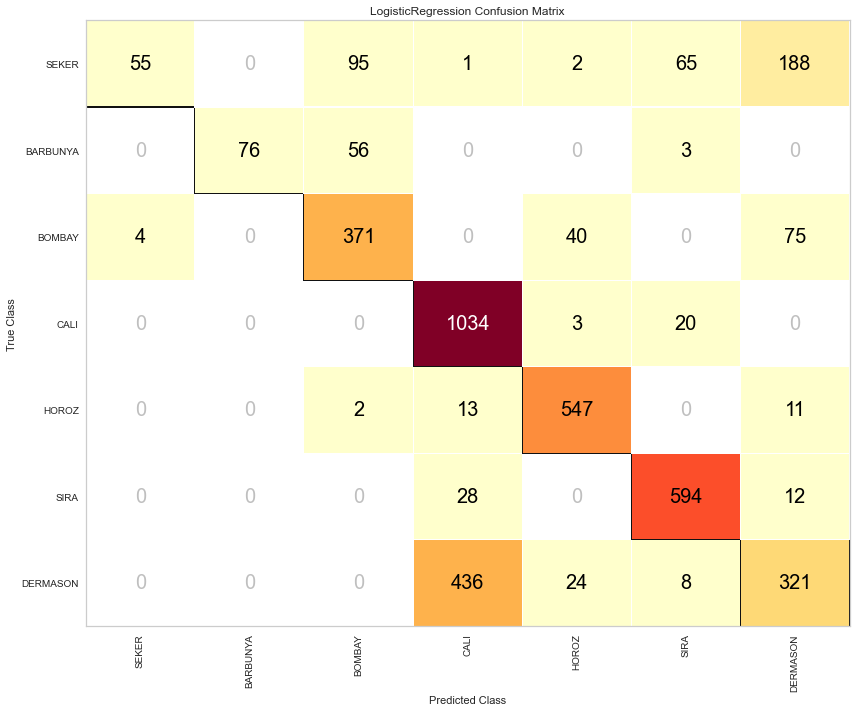

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [46]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# The ConfusionMatrix visualizer taxes a model
classes = df.Class.unique().tolist()
cm = ConfusionMatrix(model, classes=classes, percent=False)

# Fit fits the passed model (this is unnecessary if you pass the visualizer a pre-fitted model)
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() 
# on the data and then creates the confusion_matrix from scikit learn.
cm.score(X_val, y_val)

# Change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

# How did we do?
cm.poof()

### Precision, Recall, & F1 Score

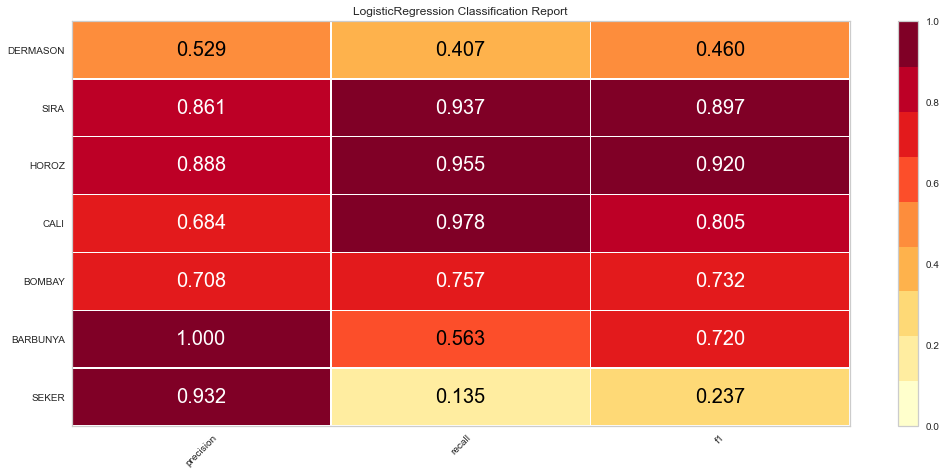

In [47]:
# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

#### ROC and AUC

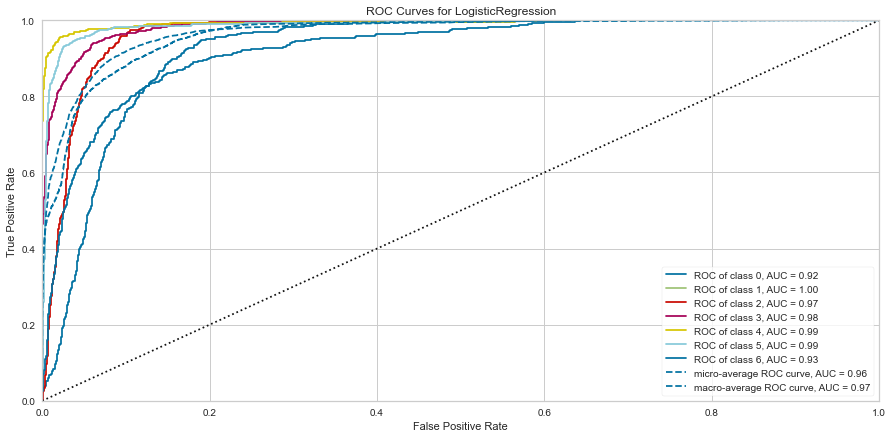

In [48]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# Encode 'Survived' and 'Not_survived'
y_train = y_train.astype('category').cat.codes
y_val = y_val.astype('category').cat.codes

# Instantiate the visualizer
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

# Try again with non-transformed data:

## Training

In [49]:
df = subsetDF

### Split Data into Training and Testing Sets

In [50]:
# Load libraries
from sklearn.model_selection import train_test_split

Create a whole features dataset that can be used for train and validation data splitting

In [51]:
# Combine the numerical features and the dummy features together
features_model = df.columns[:-1].tolist()
data_model_X = df[features_model]

# Create a whole target dataset that can be used for train and validation data splitting
data_model_y = df.Class

Separate data into training and validation and check the details of the datasets

In [52]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, 
                                                  test_size =0.3, random_state=11)
# Number of samples in each set
print(f"No. of samples in  training  set: {X_train.shape[0]}")
print(f"No. of samples in validation set: {X_val.shape[0]}")

# Survived and not-survived
print(f'\nNo. of each bean class in the training set: \n{y_train.value_counts()}\n')
print(f'No. of each bean class in the validation set: \n{y_val.value_counts()}')

No. of samples in  training  set: 9527
No. of samples in validation set: 4084

No. of each bean class in the training set: 
DERMASON    2489
SIRA        1847
SEKER       1393
HOROZ       1355
CALI        1140
BARBUNYA     916
BOMBAY       387
Name: Class, dtype: int64

No. of each bean class in the validation set: 
DERMASON    1057
SIRA         789
SEKER        634
HOROZ        573
CALI         490
BARBUNYA     406
BOMBAY       135
Name: Class, dtype: int64


## Evaluation Metrics

In [53]:
# Load libraries
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

In [54]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

### Confusion Matrix

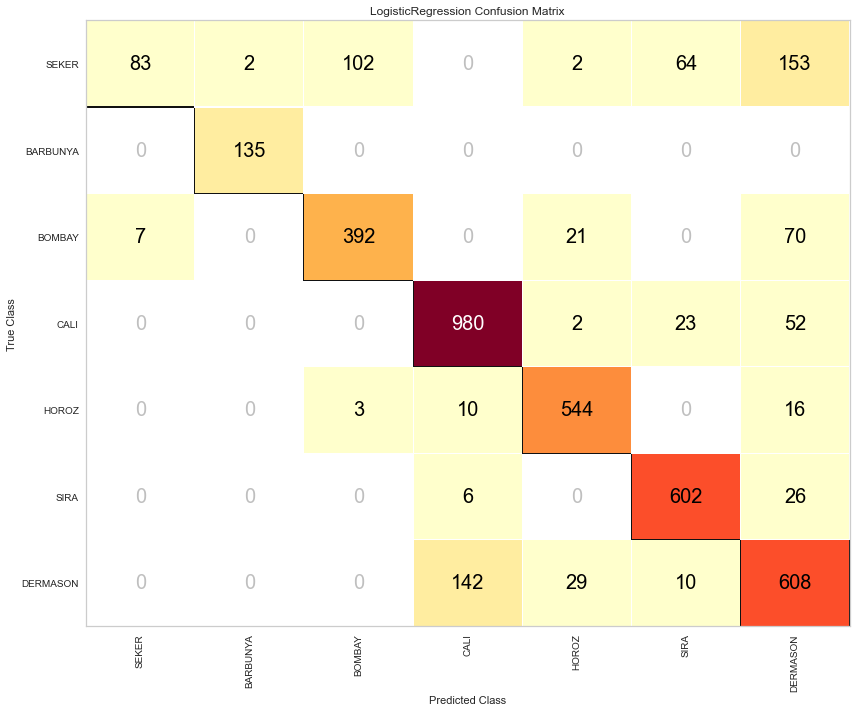

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [55]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# The ConfusionMatrix visualizer taxes a model
classes = df.Class.unique().tolist()
cm = ConfusionMatrix(model, classes=classes, percent=False)

# Fit fits the passed model (this is unnecessary if you pass the visualizer a pre-fitted model)
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() 
# on the data and then creates the confusion_matrix from scikit learn.
cm.score(X_val, y_val)

# Change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

# How did we do?
cm.poof()

### Precision, Recall, & F1 Score

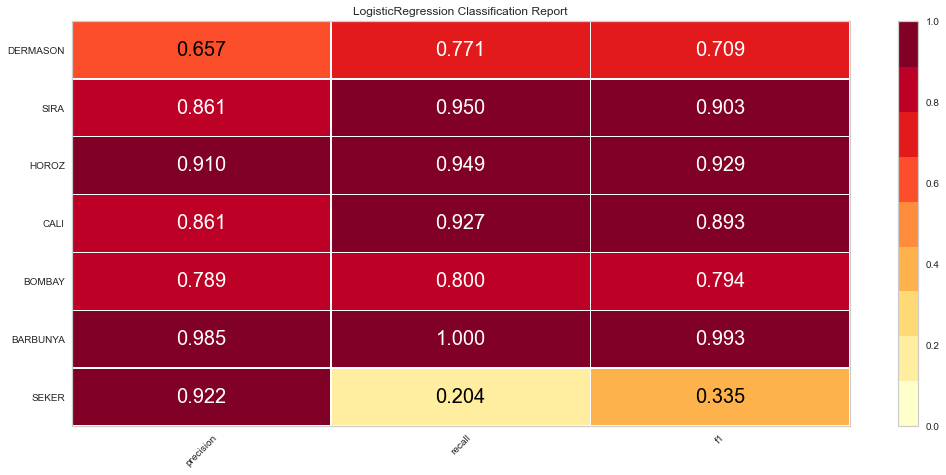

In [56]:
# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

#### ROC and AUC

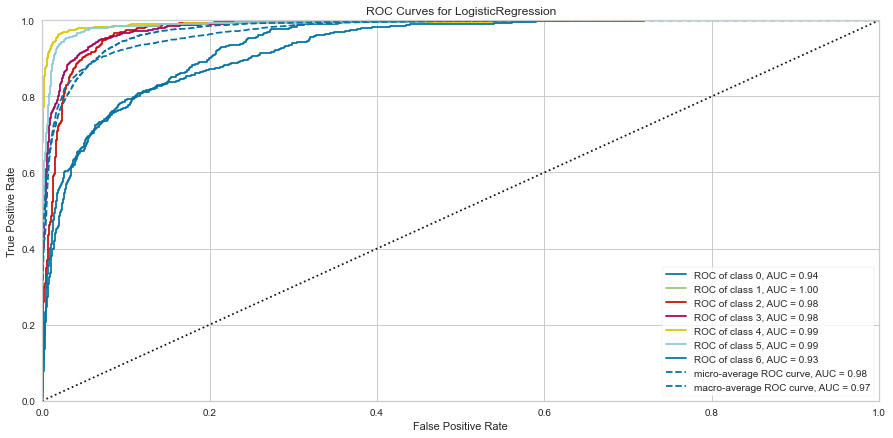

In [57]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# Encode 'Survived' and 'Not_survived'
y_train = y_train.astype('category').cat.codes
y_val = y_val.astype('category').cat.codes

# Instantiate the visualizer
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

# Try again with original data set:

## Training

In [58]:
df = beanDF

### Split Data into Training and Testing Sets

In [59]:
# Load libraries
from sklearn.model_selection import train_test_split

Create a whole features dataset that can be used for train and validation data splitting

In [60]:
# Combine the numerical features and the dummy features together
features_model = df.columns[:-1].tolist()
data_model_X = df[features_model]

# Create a whole target dataset that can be used for train and validation data splitting
data_model_y = df.Class

Separate data into training and validation and check the details of the datasets

In [61]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, 
                                                  test_size =0.3, random_state=11)
# Number of samples in each set
print(f"No. of samples in  training  set: {X_train.shape[0]}")
print(f"No. of samples in validation set: {X_val.shape[0]}")

# Survived and not-survived
print(f'\nNo. of each bean class in the training set: \n{y_train.value_counts()}\n')
print(f'No. of each bean class in the validation set: \n{y_val.value_counts()}')

No. of samples in  training  set: 9527
No. of samples in validation set: 4084

No. of each bean class in the training set: 
DERMASON    2489
SIRA        1847
SEKER       1393
HOROZ       1355
CALI        1140
BARBUNYA     916
BOMBAY       387
Name: Class, dtype: int64

No. of each bean class in the validation set: 
DERMASON    1057
SIRA         789
SEKER        634
HOROZ        573
CALI         490
BARBUNYA     406
BOMBAY       135
Name: Class, dtype: int64


## Evaluation Metrics

In [62]:
# Load libraries
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

In [63]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

### Confusion Matrix

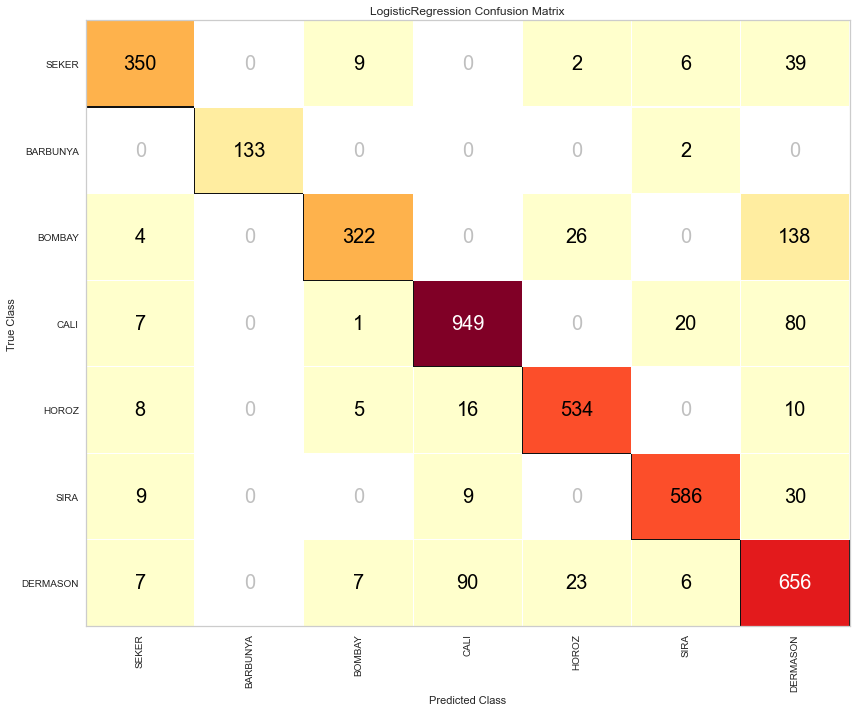

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [64]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# The ConfusionMatrix visualizer taxes a model
classes = df.Class.unique().tolist()
cm = ConfusionMatrix(model, classes=classes, percent=False)

# Fit fits the passed model (this is unnecessary if you pass the visualizer a pre-fitted model)
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() 
# on the data and then creates the confusion_matrix from scikit learn.
cm.score(X_val, y_val)

# Change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

# How did we do?
cm.poof()

### Precision, Recall, & F1 Score

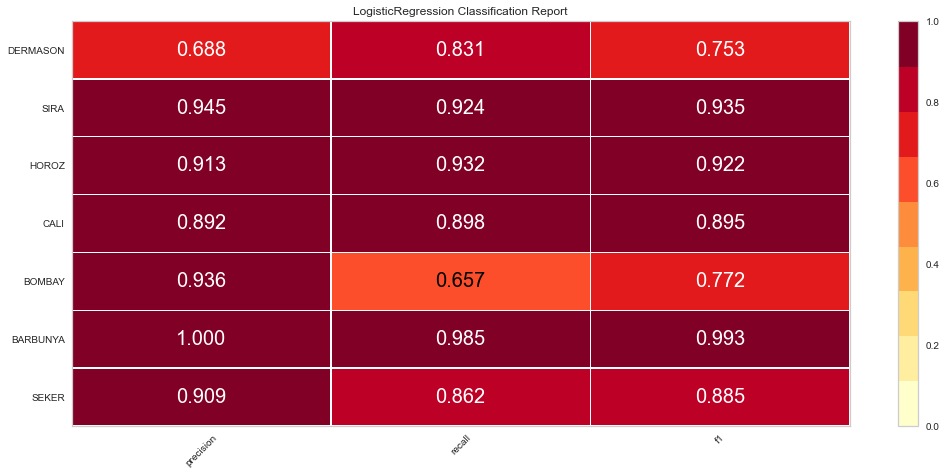

In [65]:
# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

#### ROC and AUC

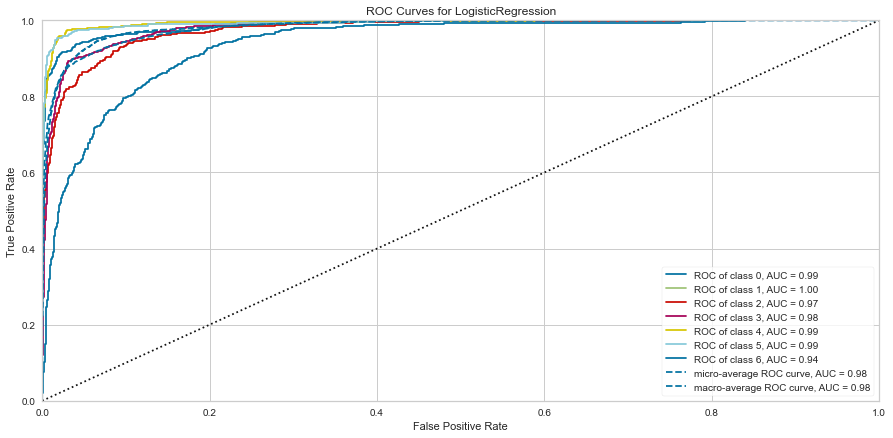

In [66]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# Encode 'Survived' and 'Not_survived'
y_train = y_train.astype('category').cat.codes
y_val = y_val.astype('category').cat.codes

# Instantiate the visualizer
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

# Try again starting with just the most useful predictor:

Note: Only 1 bean was predicted when using just SF2; I had to get to 11 before all beans were predicted.

In [67]:
feat_list = ranked.Features[:11].tolist() + ['Class']

In [68]:
df = beanDF[feat_list]

In [69]:
df.shape

(13611, 12)

In [70]:
df.columns

Index(['ShapeFactor2', 'ShapeFactor1', 'Compactness', 'ShapeFactor3',
       'Solidity', 'AspectRation', 'roundness', 'Eccentricity', 'ShapeFactor4',
       'Extent', 'MinorAxisLength', 'Class'],
      dtype='object')

In [71]:
df

,ShapeFactor2,ShapeFactor1,Compactness,ShapeFactor3,Solidity,AspectRation,roundness,Eccentricity,ShapeFactor4,Extent,MinorAxisLength,Class
0,0.003147,0.007332,0.913358,0.834222,0.988856,1.197191,0.958027,0.549812,0.998724,0.763923,173.888747,SEKER
1,0.003564,0.006979,0.953861,0.909851,0.984986,1.097356,0.887034,0.411785,0.998430,0.783968,182.734419,SEKER
2,0.003048,0.007244,0.908774,0.825871,0.989559,1.209713,0.947849,0.562727,0.999066,0.778113,175.931143,SEKER
3,0.003215,0.007017,0.928329,0.861794,0.976696,1.153638,0.903936,0.498616,0.994199,0.782681,182.516516,SEKER
4,0.003665,0.006697,0.970516,0.941900,0.990893,1.060798,0.984877,0.333680,0.999166,0.773098,190.279279,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...
13606,0.001749,0.006858,0.801865,0.642988,0.990331,1.552728,0.916603,0.765002,0.998385,0.714574,185.944705,DERMASON
13607,0.001886,0.006688,0.822252,0.676099,0.990752,1.476439,0.922015,0.735702,0.998219,0.799943,190.713136,DERMASON
13608,0.001888,0.006681,0.822730,0.676884,0.989899,1.472582,0.918424,0.734065,0.996767,0.729932,191.187979,DERMASON
13609,0.001852,0.006724,0.817457,0.668237,0.987813,1.489326,0.907906,0.741055,0.995222,0.705389,190.275731,DERMASON


## Training

### Split Data into Training and Testing Sets

In [72]:
# Load libraries
from sklearn.model_selection import train_test_split

Create a whole features dataset that can be used for train and validation data splitting

In [73]:
# Combine the numerical features and the dummy features together
features_model = df.columns[:-1].tolist()
data_model_X = df[features_model]

# Create a whole target dataset that can be used for train and validation data splitting
data_model_y = df.Class

Separate data into training and validation and check the details of the datasets

In [74]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, 
                                                  test_size =0.3, random_state=11)
# Number of samples in each set
print(f"No. of samples in  training  set: {X_train.shape[0]}")
print(f"No. of samples in validation set: {X_val.shape[0]}")

# Survived and not-survived
print(f'\nNo. of each bean class in the training set: \n{y_train.value_counts()}\n')
print(f'No. of each bean class in the validation set: \n{y_val.value_counts()}')

No. of samples in  training  set: 9527
No. of samples in validation set: 4084

No. of each bean class in the training set: 
DERMASON    2489
SIRA        1847
SEKER       1393
HOROZ       1355
CALI        1140
BARBUNYA     916
BOMBAY       387
Name: Class, dtype: int64

No. of each bean class in the validation set: 
DERMASON    1057
SIRA         789
SEKER        634
HOROZ        573
CALI         490
BARBUNYA     406
BOMBAY       135
Name: Class, dtype: int64


## Evaluation Metrics

In [75]:
# Load libraries
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

In [76]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

### Confusion Matrix

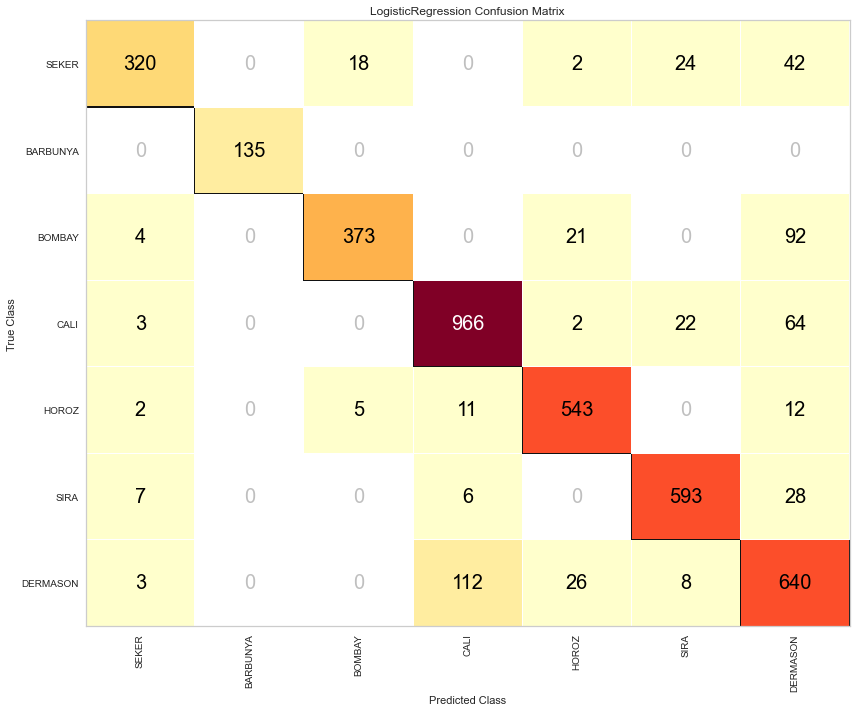

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [77]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# The ConfusionMatrix visualizer taxes a model
classes = df.Class.unique().tolist()
cm = ConfusionMatrix(model, classes=classes, percent=False)

# Fit fits the passed model (this is unnecessary if you pass the visualizer a pre-fitted model)
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() 
# on the data and then creates the confusion_matrix from scikit learn.
cm.score(X_val, y_val)

# Change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

# How did we do?
cm.poof()

### Precision, Recall, & F1 Score

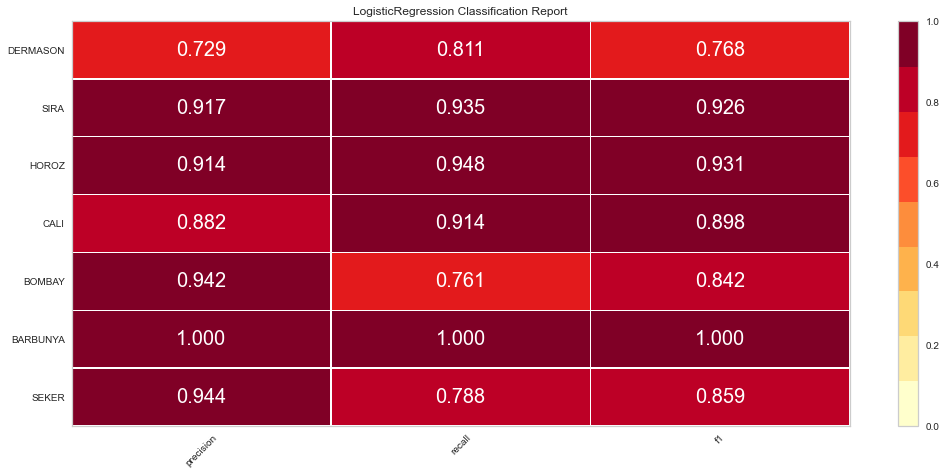

In [78]:
# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

#### ROC and AUC

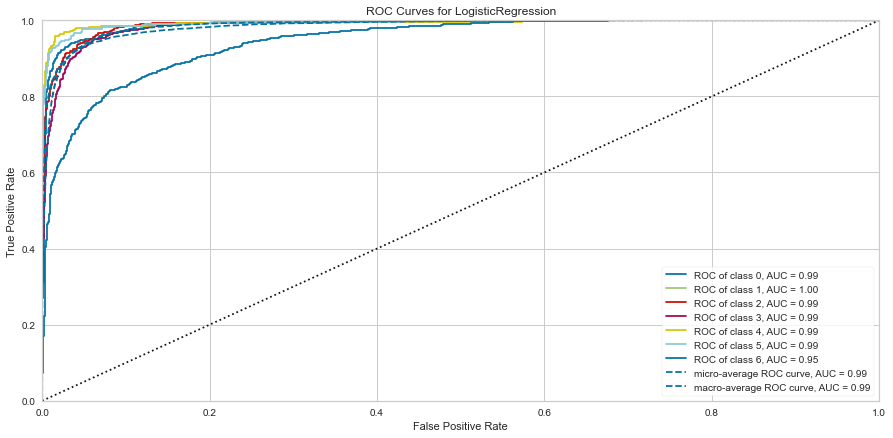

In [79]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# Encode 'Survived' and 'Not_survived'
y_train = y_train.astype('category').cat.codes
y_val = y_val.astype('category').cat.codes

# Instantiate the visualizer
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

# Try again starting with just the most useful predictor:

## 12

In [80]:
feat_list = ranked.Features[:12].tolist() + ['Class']

In [81]:
df = beanDF[feat_list]

In [82]:
df.shape

(13611, 13)

In [83]:
df.columns

Index(['ShapeFactor2', 'ShapeFactor1', 'Compactness', 'ShapeFactor3',
       'Solidity', 'AspectRation', 'roundness', 'Eccentricity', 'ShapeFactor4',
       'Extent', 'MinorAxisLength', 'EquivDiameter', 'Class'],
      dtype='object')

In [84]:
df

,ShapeFactor2,ShapeFactor1,Compactness,ShapeFactor3,Solidity,AspectRation,roundness,Eccentricity,ShapeFactor4,Extent,MinorAxisLength,EquivDiameter,Class
0,0.003147,0.007332,0.913358,0.834222,0.988856,1.197191,0.958027,0.549812,0.998724,0.763923,173.888747,190.141097,SEKER
1,0.003564,0.006979,0.953861,0.909851,0.984986,1.097356,0.887034,0.411785,0.998430,0.783968,182.734419,191.272750,SEKER
2,0.003048,0.007244,0.908774,0.825871,0.989559,1.209713,0.947849,0.562727,0.999066,0.778113,175.931143,193.410904,SEKER
3,0.003215,0.007017,0.928329,0.861794,0.976696,1.153638,0.903936,0.498616,0.994199,0.782681,182.516516,195.467062,SEKER
4,0.003665,0.006697,0.970516,0.941900,0.990893,1.060798,0.984877,0.333680,0.999166,0.773098,190.279279,195.896503,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,0.001749,0.006858,0.801865,0.642988,0.990331,1.552728,0.916603,0.765002,0.998385,0.714574,185.944705,231.515799,DERMASON
13607,0.001886,0.006688,0.822252,0.676099,0.990752,1.476439,0.922015,0.735702,0.998219,0.799943,190.713136,231.526798,DERMASON
13608,0.001888,0.006681,0.822730,0.676884,0.989899,1.472582,0.918424,0.734065,0.996767,0.729932,191.187979,231.631261,DERMASON
13609,0.001852,0.006724,0.817457,0.668237,0.987813,1.489326,0.907906,0.741055,0.995222,0.705389,190.275731,231.653248,DERMASON


## Training

### Split Data into Training and Testing Sets

In [85]:
# Load libraries
from sklearn.model_selection import train_test_split

Create a whole features dataset that can be used for train and validation data splitting

In [86]:
# Combine the numerical features and the dummy features together
features_model = df.columns[:-1].tolist()
data_model_X = df[features_model]

# Create a whole target dataset that can be used for train and validation data splitting
data_model_y = df.Class

Separate data into training and validation and check the details of the datasets

In [87]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, 
                                                  test_size =0.3, random_state=11)
# Number of samples in each set
print(f"No. of samples in  training  set: {X_train.shape[0]}")
print(f"No. of samples in validation set: {X_val.shape[0]}")

# Survived and not-survived
print(f'\nNo. of each bean class in the training set: \n{y_train.value_counts()}\n')
print(f'No. of each bean class in the validation set: \n{y_val.value_counts()}')

No. of samples in  training  set: 9527
No. of samples in validation set: 4084

No. of each bean class in the training set: 
DERMASON    2489
SIRA        1847
SEKER       1393
HOROZ       1355
CALI        1140
BARBUNYA     916
BOMBAY       387
Name: Class, dtype: int64

No. of each bean class in the validation set: 
DERMASON    1057
SIRA         789
SEKER        634
HOROZ        573
CALI         490
BARBUNYA     406
BOMBAY       135
Name: Class, dtype: int64


## Evaluation Metrics

In [88]:
# Load libraries
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

In [89]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

### Confusion Matrix

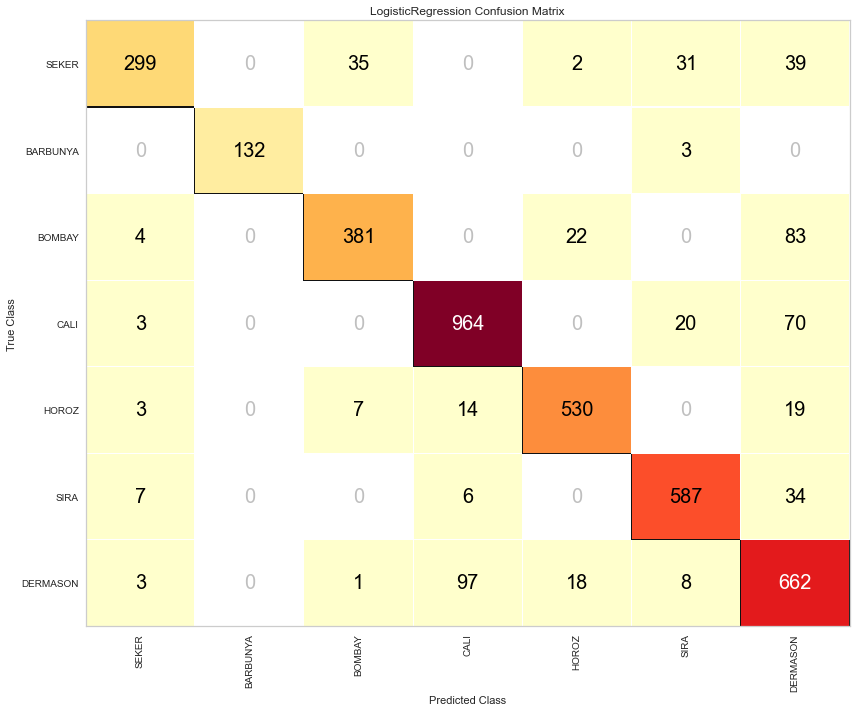

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [90]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# The ConfusionMatrix visualizer taxes a model
classes = df.Class.unique().tolist()
cm = ConfusionMatrix(model, classes=classes, percent=False)

# Fit fits the passed model (this is unnecessary if you pass the visualizer a pre-fitted model)
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() 
# on the data and then creates the confusion_matrix from scikit learn.
cm.score(X_val, y_val)

# Change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

# How did we do?
cm.poof()

### Precision, Recall, & F1 Score

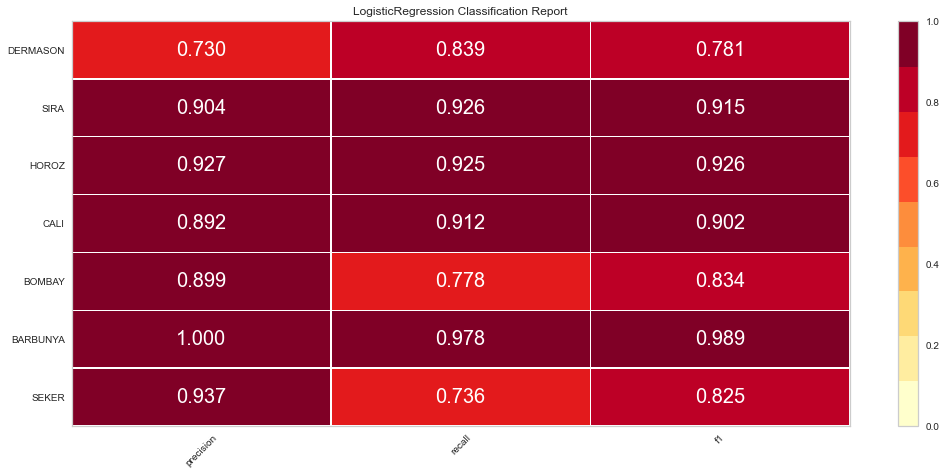

In [91]:
# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

#### ROC and AUC

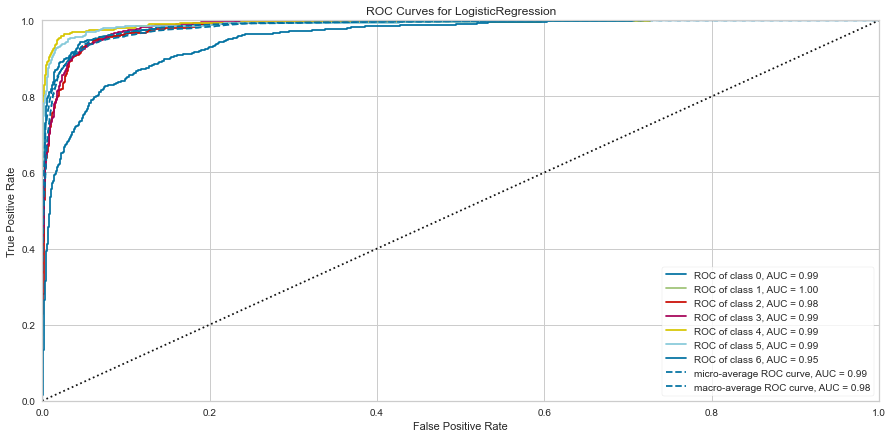

In [92]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# Encode 'Survived' and 'Not_survived'
y_train = y_train.astype('category').cat.codes
y_val = y_val.astype('category').cat.codes

# Instantiate the visualizer
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

# Try again starting with just the most useful predictor:

## 13

In [93]:
feat_list = ranked.Features[:13].tolist() + ['Class']

In [94]:
df = beanDF[feat_list]

In [95]:
df.shape

(13611, 14)

In [96]:
df.columns

Index(['ShapeFactor2', 'ShapeFactor1', 'Compactness', 'ShapeFactor3',
       'Solidity', 'AspectRation', 'roundness', 'Eccentricity', 'ShapeFactor4',
       'Extent', 'MinorAxisLength', 'EquivDiameter', 'Perimeter', 'Class'],
      dtype='object')

In [97]:
df

,ShapeFactor2,ShapeFactor1,Compactness,ShapeFactor3,Solidity,AspectRation,roundness,Eccentricity,ShapeFactor4,Extent,MinorAxisLength,EquivDiameter,Perimeter,Class
0,0.003147,0.007332,0.913358,0.834222,0.988856,1.197191,0.958027,0.549812,0.998724,0.763923,173.888747,190.141097,610.291,SEKER
1,0.003564,0.006979,0.953861,0.909851,0.984986,1.097356,0.887034,0.411785,0.998430,0.783968,182.734419,191.272750,638.018,SEKER
2,0.003048,0.007244,0.908774,0.825871,0.989559,1.209713,0.947849,0.562727,0.999066,0.778113,175.931143,193.410904,624.110,SEKER
3,0.003215,0.007017,0.928329,0.861794,0.976696,1.153638,0.903936,0.498616,0.994199,0.782681,182.516516,195.467062,645.884,SEKER
4,0.003665,0.006697,0.970516,0.941900,0.990893,1.060798,0.984877,0.333680,0.999166,0.773098,190.279279,195.896503,620.134,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,0.001749,0.006858,0.801865,0.642988,0.990331,1.552728,0.916603,0.765002,0.998385,0.714574,185.944705,231.515799,759.696,DERMASON
13607,0.001886,0.006688,0.822252,0.676099,0.990752,1.476439,0.922015,0.735702,0.998219,0.799943,190.713136,231.526798,757.499,DERMASON
13608,0.001888,0.006681,0.822730,0.676884,0.989899,1.472582,0.918424,0.734065,0.996767,0.729932,191.187979,231.631261,759.321,DERMASON
13609,0.001852,0.006724,0.817457,0.668237,0.987813,1.489326,0.907906,0.741055,0.995222,0.705389,190.275731,231.653248,763.779,DERMASON


## Training

### Split Data into Training and Testing Sets

In [98]:
# Load libraries
from sklearn.model_selection import train_test_split

Create a whole features dataset that can be used for train and validation data splitting

In [99]:
# Combine the numerical features and the dummy features together
features_model = df.columns[:-1].tolist()
data_model_X = df[features_model]

# Create a whole target dataset that can be used for train and validation data splitting
data_model_y = df.Class

Separate data into training and validation and check the details of the datasets

In [100]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, 
                                                  test_size =0.3, random_state=11)
# Number of samples in each set
print(f"No. of samples in  training  set: {X_train.shape[0]}")
print(f"No. of samples in validation set: {X_val.shape[0]}")

# Survived and not-survived
print(f'\nNo. of each bean class in the training set: \n{y_train.value_counts()}\n')
print(f'No. of each bean class in the validation set: \n{y_val.value_counts()}')

No. of samples in  training  set: 9527
No. of samples in validation set: 4084

No. of each bean class in the training set: 
DERMASON    2489
SIRA        1847
SEKER       1393
HOROZ       1355
CALI        1140
BARBUNYA     916
BOMBAY       387
Name: Class, dtype: int64

No. of each bean class in the validation set: 
DERMASON    1057
SIRA         789
SEKER        634
HOROZ        573
CALI         490
BARBUNYA     406
BOMBAY       135
Name: Class, dtype: int64


## Evaluation Metrics

In [101]:
# Load libraries
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

In [102]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

### Confusion Matrix

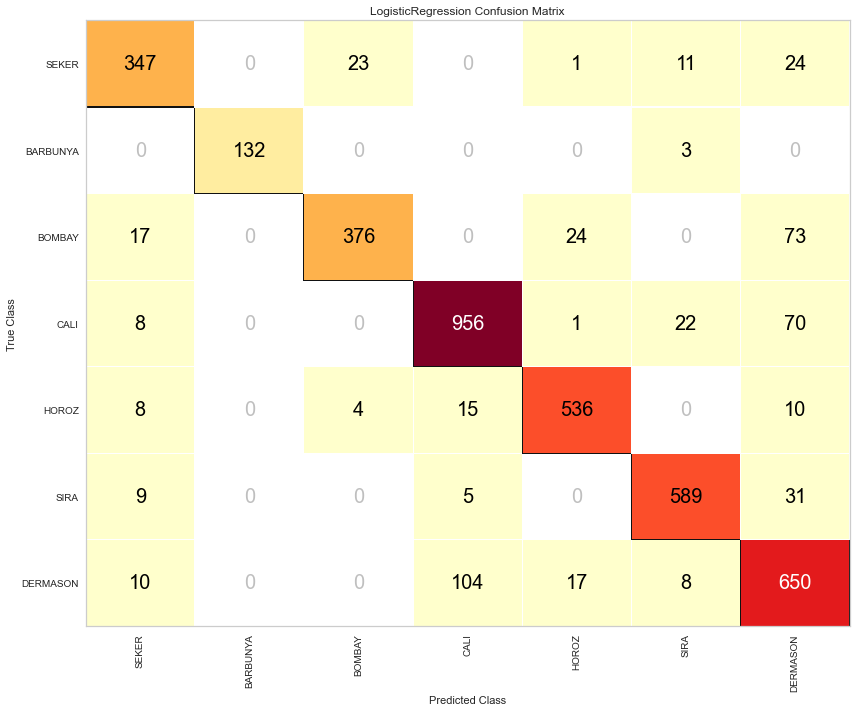

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [103]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# The ConfusionMatrix visualizer taxes a model
classes = df.Class.unique().tolist()
cm = ConfusionMatrix(model, classes=classes, percent=False)

# Fit fits the passed model (this is unnecessary if you pass the visualizer a pre-fitted model)
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() 
# on the data and then creates the confusion_matrix from scikit learn.
cm.score(X_val, y_val)

# Change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

# How did we do?
cm.poof()

### Precision, Recall, & F1 Score

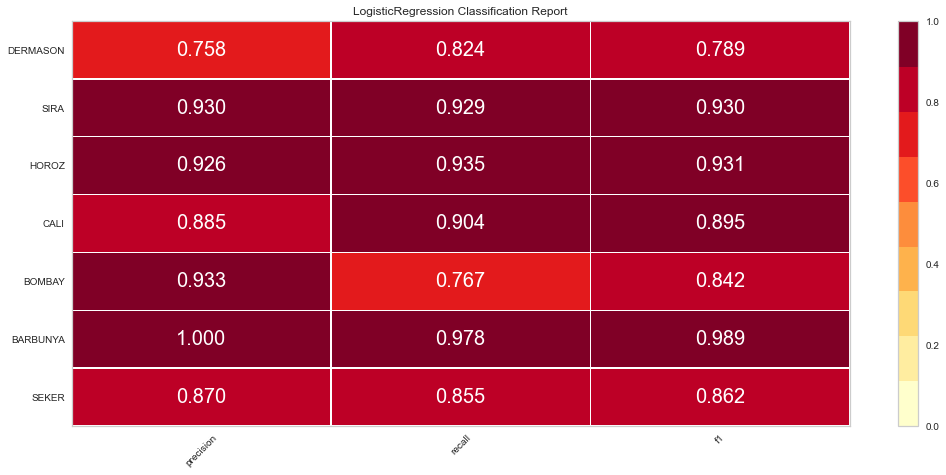

In [104]:
# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

#### ROC and AUC

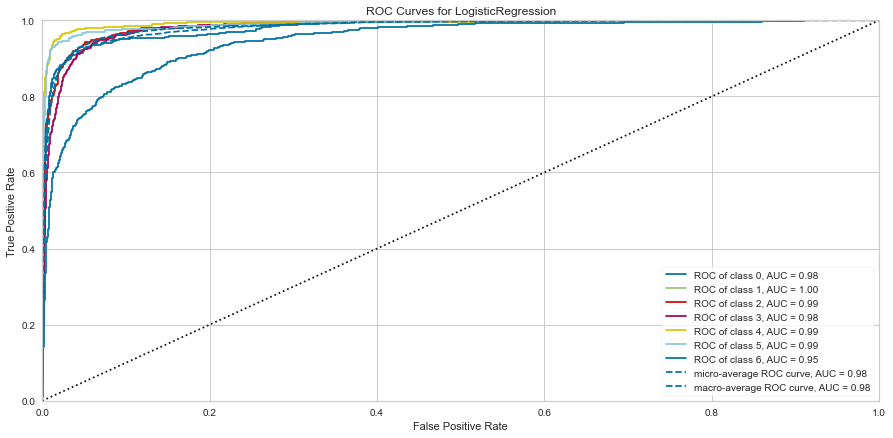

In [105]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# Encode 'Survived' and 'Not_survived'
y_train = y_train.astype('category').cat.codes
y_val = y_val.astype('category').cat.codes

# Instantiate the visualizer
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

# Try again starting with just the most useful predictor:

## 14

In [106]:
feat_list = ranked.Features[:14].tolist() + ['Class']

In [107]:
df = beanDF[feat_list]

In [108]:
df.shape

(13611, 15)

In [109]:
df.columns

Index(['ShapeFactor2', 'ShapeFactor1', 'Compactness', 'ShapeFactor3',
       'Solidity', 'AspectRation', 'roundness', 'Eccentricity', 'ShapeFactor4',
       'Extent', 'MinorAxisLength', 'EquivDiameter', 'Perimeter',
       'MajorAxisLength', 'Class'],
      dtype='object')

In [110]:
df

,ShapeFactor2,ShapeFactor1,Compactness,ShapeFactor3,Solidity,AspectRation,roundness,Eccentricity,ShapeFactor4,Extent,MinorAxisLength,EquivDiameter,Perimeter,MajorAxisLength,Class
0,0.003147,0.007332,0.913358,0.834222,0.988856,1.197191,0.958027,0.549812,0.998724,0.763923,173.888747,190.141097,610.291,208.178117,SEKER
1,0.003564,0.006979,0.953861,0.909851,0.984986,1.097356,0.887034,0.411785,0.998430,0.783968,182.734419,191.272750,638.018,200.524796,SEKER
2,0.003048,0.007244,0.908774,0.825871,0.989559,1.209713,0.947849,0.562727,0.999066,0.778113,175.931143,193.410904,624.110,212.826130,SEKER
3,0.003215,0.007017,0.928329,0.861794,0.976696,1.153638,0.903936,0.498616,0.994199,0.782681,182.516516,195.467062,645.884,210.557999,SEKER
4,0.003665,0.006697,0.970516,0.941900,0.990893,1.060798,0.984877,0.333680,0.999166,0.773098,190.279279,195.896503,620.134,201.847882,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,0.001749,0.006858,0.801865,0.642988,0.990331,1.552728,0.916603,0.765002,0.998385,0.714574,185.944705,231.515799,759.696,288.721612,DERMASON
13607,0.001886,0.006688,0.822252,0.676099,0.990752,1.476439,0.922015,0.735702,0.998219,0.799943,190.713136,231.526798,757.499,281.576392,DERMASON
13608,0.001888,0.006681,0.822730,0.676884,0.989899,1.472582,0.918424,0.734065,0.996767,0.729932,191.187979,231.631261,759.321,281.539928,DERMASON
13609,0.001852,0.006724,0.817457,0.668237,0.987813,1.489326,0.907906,0.741055,0.995222,0.705389,190.275731,231.653248,763.779,283.382636,DERMASON


## Training

### Split Data into Training and Testing Sets

In [111]:
# Load libraries
from sklearn.model_selection import train_test_split

Create a whole features dataset that can be used for train and validation data splitting

In [112]:
# Combine the numerical features and the dummy features together
features_model = df.columns[:-1].tolist()
data_model_X = df[features_model]

# Create a whole target dataset that can be used for train and validation data splitting
data_model_y = df.Class

Separate data into training and validation and check the details of the datasets

In [113]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, 
                                                  test_size =0.3, random_state=11)
# Number of samples in each set
print(f"No. of samples in  training  set: {X_train.shape[0]}")
print(f"No. of samples in validation set: {X_val.shape[0]}")

# Survived and not-survived
print(f'\nNo. of each bean class in the training set: \n{y_train.value_counts()}\n')
print(f'No. of each bean class in the validation set: \n{y_val.value_counts()}')

No. of samples in  training  set: 9527
No. of samples in validation set: 4084

No. of each bean class in the training set: 
DERMASON    2489
SIRA        1847
SEKER       1393
HOROZ       1355
CALI        1140
BARBUNYA     916
BOMBAY       387
Name: Class, dtype: int64

No. of each bean class in the validation set: 
DERMASON    1057
SIRA         789
SEKER        634
HOROZ        573
CALI         490
BARBUNYA     406
BOMBAY       135
Name: Class, dtype: int64


## Evaluation Metrics

In [114]:
# Load libraries
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

In [115]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

### Confusion Matrix

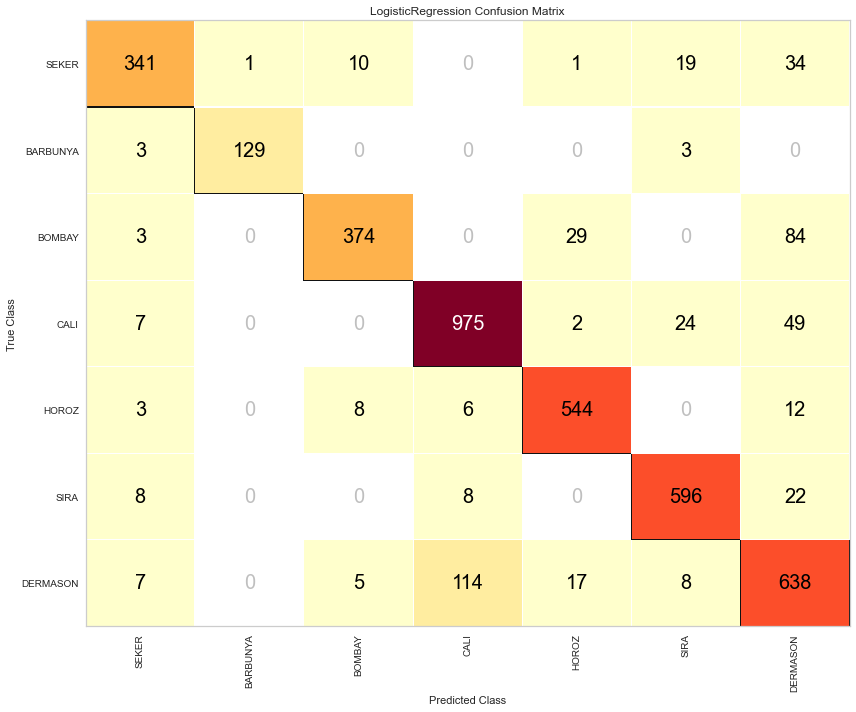

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [116]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# The ConfusionMatrix visualizer taxes a model
classes = df.Class.unique().tolist()
cm = ConfusionMatrix(model, classes=classes, percent=False)

# Fit fits the passed model (this is unnecessary if you pass the visualizer a pre-fitted model)
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() 
# on the data and then creates the confusion_matrix from scikit learn.
cm.score(X_val, y_val)

# Change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

# How did we do?
cm.poof()

### Precision, Recall, & F1 Score

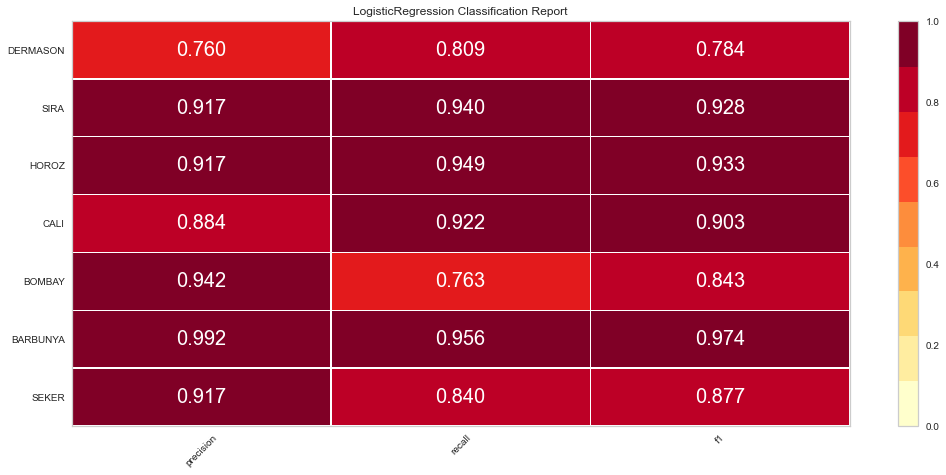

In [117]:
# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

#### ROC and AUC

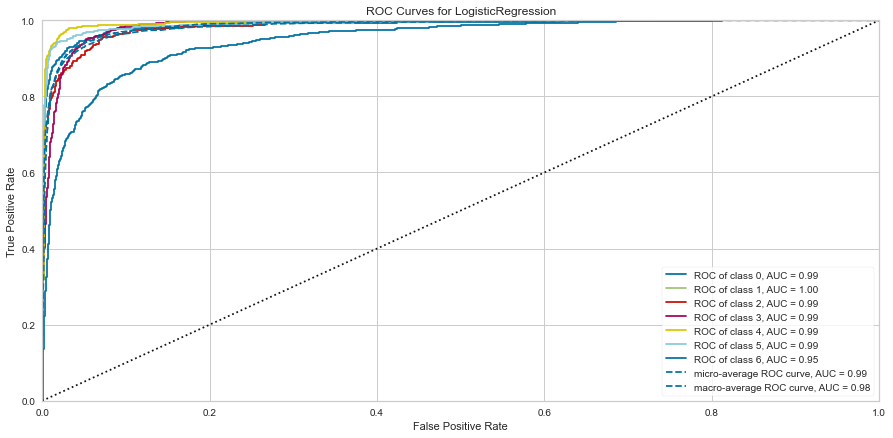

In [118]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# Encode 'Survived' and 'Not_survived'
y_train = y_train.astype('category').cat.codes
y_val = y_val.astype('category').cat.codes

# Instantiate the visualizer
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

# Try again starting with just the most useful predictor:

## 15

In [119]:
feat_list = ranked.Features[:15].tolist() + ['Class']

In [120]:
df = beanDF[feat_list]

In [121]:
df.shape

(13611, 16)

In [122]:
df.columns

Index(['ShapeFactor2', 'ShapeFactor1', 'Compactness', 'ShapeFactor3',
       'Solidity', 'AspectRation', 'roundness', 'Eccentricity', 'ShapeFactor4',
       'Extent', 'MinorAxisLength', 'EquivDiameter', 'Perimeter',
       'MajorAxisLength', 'Area', 'Class'],
      dtype='object')

In [123]:
df

,ShapeFactor2,ShapeFactor1,Compactness,ShapeFactor3,Solidity,AspectRation,roundness,Eccentricity,ShapeFactor4,Extent,MinorAxisLength,EquivDiameter,Perimeter,MajorAxisLength,Area,Class
0,0.003147,0.007332,0.913358,0.834222,0.988856,1.197191,0.958027,0.549812,0.998724,0.763923,173.888747,190.141097,610.291,208.178117,28395,SEKER
1,0.003564,0.006979,0.953861,0.909851,0.984986,1.097356,0.887034,0.411785,0.998430,0.783968,182.734419,191.272750,638.018,200.524796,28734,SEKER
2,0.003048,0.007244,0.908774,0.825871,0.989559,1.209713,0.947849,0.562727,0.999066,0.778113,175.931143,193.410904,624.110,212.826130,29380,SEKER
3,0.003215,0.007017,0.928329,0.861794,0.976696,1.153638,0.903936,0.498616,0.994199,0.782681,182.516516,195.467062,645.884,210.557999,30008,SEKER
4,0.003665,0.006697,0.970516,0.941900,0.990893,1.060798,0.984877,0.333680,0.999166,0.773098,190.279279,195.896503,620.134,201.847882,30140,SEKER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13606,0.001749,0.006858,0.801865,0.642988,0.990331,1.552728,0.916603,0.765002,0.998385,0.714574,185.944705,231.515799,759.696,288.721612,42097,DERMASON
13607,0.001886,0.006688,0.822252,0.676099,0.990752,1.476439,0.922015,0.735702,0.998219,0.799943,190.713136,231.526798,757.499,281.576392,42101,DERMASON
13608,0.001888,0.006681,0.822730,0.676884,0.989899,1.472582,0.918424,0.734065,0.996767,0.729932,191.187979,231.631261,759.321,281.539928,42139,DERMASON
13609,0.001852,0.006724,0.817457,0.668237,0.987813,1.489326,0.907906,0.741055,0.995222,0.705389,190.275731,231.653248,763.779,283.382636,42147,DERMASON


## Training

### Split Data into Training and Testing Sets

In [124]:
# Load libraries
from sklearn.model_selection import train_test_split

Create a whole features dataset that can be used for train and validation data splitting

In [125]:
# Combine the numerical features and the dummy features together
features_model = df.columns[:-1].tolist()
data_model_X = df[features_model]

# Create a whole target dataset that can be used for train and validation data splitting
data_model_y = df.Class

Separate data into training and validation and check the details of the datasets

In [126]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, 
                                                  test_size =0.3, random_state=11)
# Number of samples in each set
print(f"No. of samples in  training  set: {X_train.shape[0]}")
print(f"No. of samples in validation set: {X_val.shape[0]}")

# Survived and not-survived
print(f'\nNo. of each bean class in the training set: \n{y_train.value_counts()}\n')
print(f'No. of each bean class in the validation set: \n{y_val.value_counts()}')

No. of samples in  training  set: 9527
No. of samples in validation set: 4084

No. of each bean class in the training set: 
DERMASON    2489
SIRA        1847
SEKER       1393
HOROZ       1355
CALI        1140
BARBUNYA     916
BOMBAY       387
Name: Class, dtype: int64

No. of each bean class in the validation set: 
DERMASON    1057
SIRA         789
SEKER        634
HOROZ        573
CALI         490
BARBUNYA     406
BOMBAY       135
Name: Class, dtype: int64


## Evaluation Metrics

In [127]:
# Load libraries
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

In [128]:
# Set up the figure size
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

### Confusion Matrix

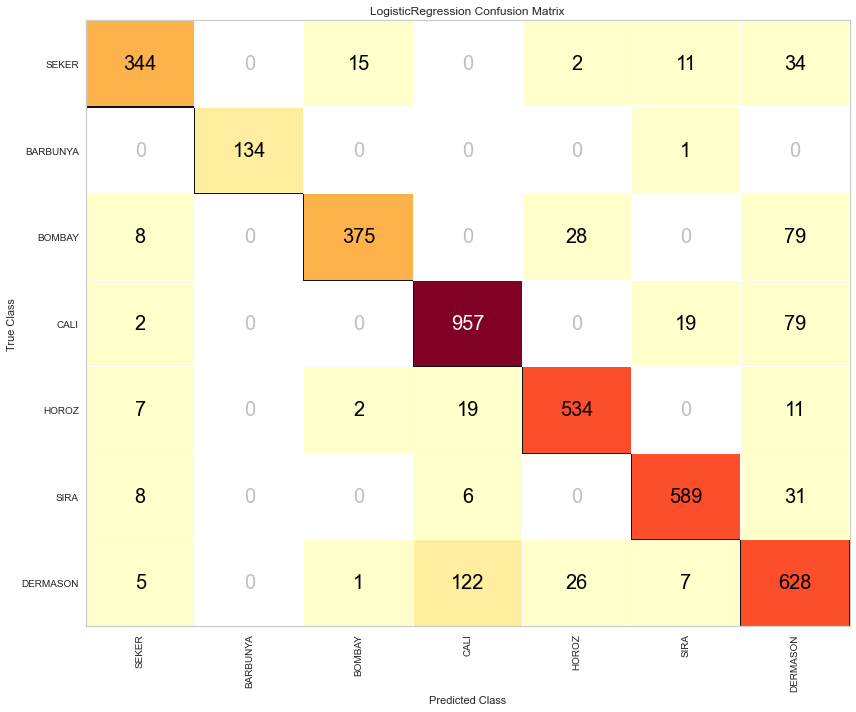

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [129]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# The ConfusionMatrix visualizer taxes a model
classes = df.Class.unique().tolist()
cm = ConfusionMatrix(model, classes=classes, percent=False)

# Fit fits the passed model (this is unnecessary if you pass the visualizer a pre-fitted model)
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() 
# on the data and then creates the confusion_matrix from scikit learn.
cm.score(X_val, y_val)

# Change fontsize of the labels in the figure
for label in cm.ax.texts:
    label.set_size(20)

# How did we do?
cm.poof()

### Precision, Recall, & F1 Score

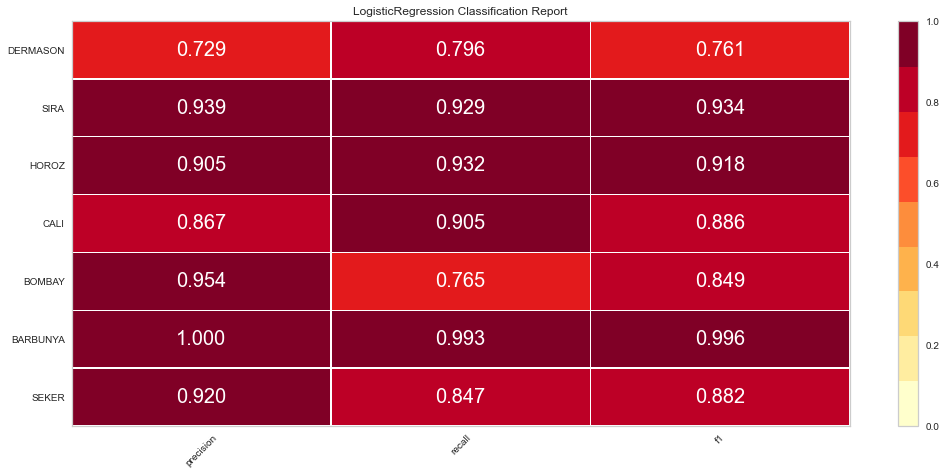

In [130]:
# set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(model, classes=classes)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

#### ROC and AUC

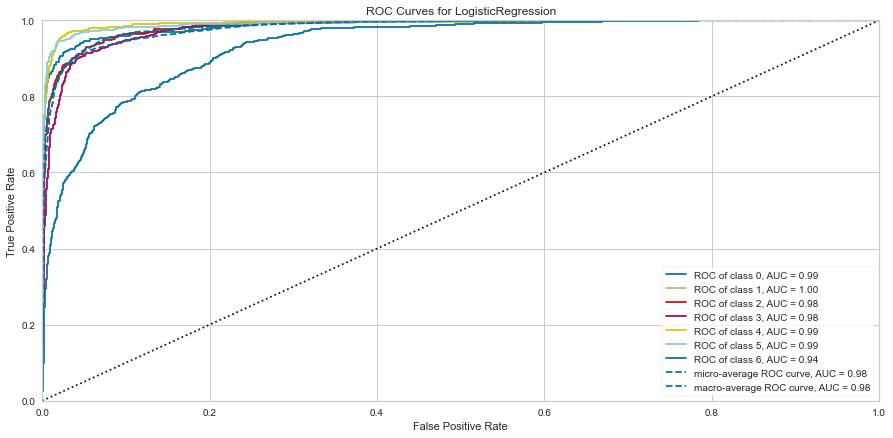

In [131]:
# Instantiate the classification model 
model = LogisticRegression(solver='liblinear')

# Encode 'Survived' and 'Not_survived'
y_train = y_train.astype('category').cat.codes
y_val = y_val.astype('category').cat.codes

# Instantiate the visualizer
visualizer = ROCAUC(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_val, y_val)  # Evaluate the model on the test data
g = visualizer.poof()

In [132]:
df.dtypes

ShapeFactor2       float64
ShapeFactor1       float64
Compactness        float64
ShapeFactor3       float64
Solidity           float64
AspectRation       float64
roundness          float64
Eccentricity       float64
ShapeFactor4       float64
Extent             float64
MinorAxisLength    float64
EquivDiameter      float64
Perimeter          float64
MajorAxisLength    float64
Area                 int64
Class               object
dtype: object

## Looks like we peak around the top 12 features:

In [133]:
np.arange(11, 16)

array([11, 12, 13, 14, 15])

In [134]:
def prec_rec_f1(df):
    '''Creates a model and outputs Precision, Recall, & F1
    table based on DataFrame input.'''

    # Combine the numerical features and the dummy features together
    features_model = df.columns[:-1].tolist()
    data_model_X = df[features_model]

    # Create a whole target dataset that can be used for train and validation data splitting
    data_model_y = df.Class
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, 
                                                      test_size =0.3, random_state=11)
    
    # Instantiate the classification model 
    model = LogisticRegression(solver='liblinear')
    classes = df.Class.unique().tolist()
    
    # Instantiate the visualizer
    visualizer = ClassificationReport(model, classes=classes)

    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_val, y_val)  # Evaluate the model on the test data
    g = visualizer.poof()

Top 11 features:


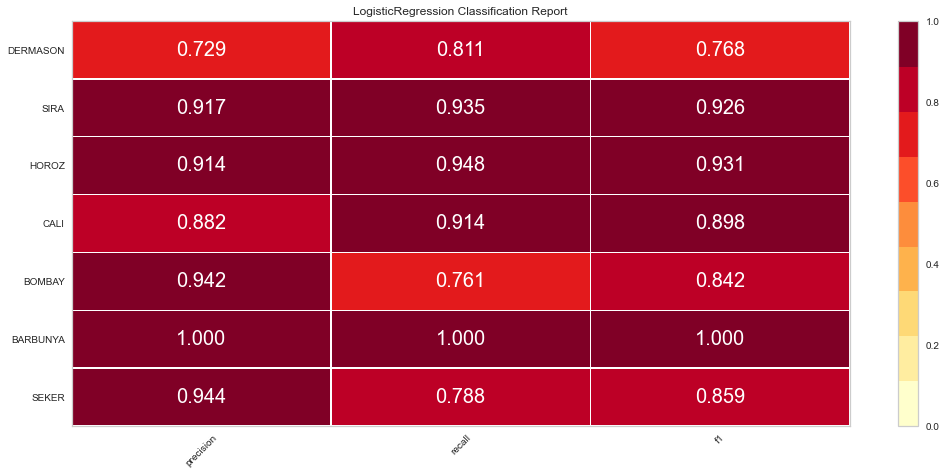

Top 12 features:


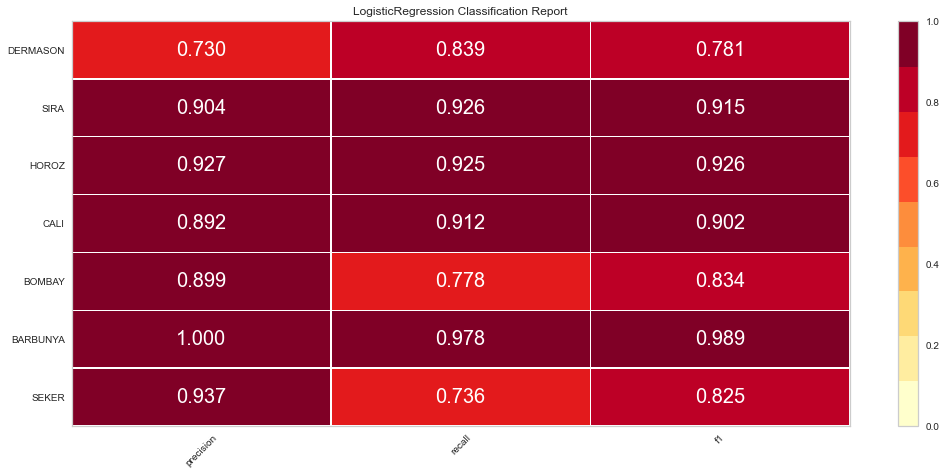

Top 13 features:


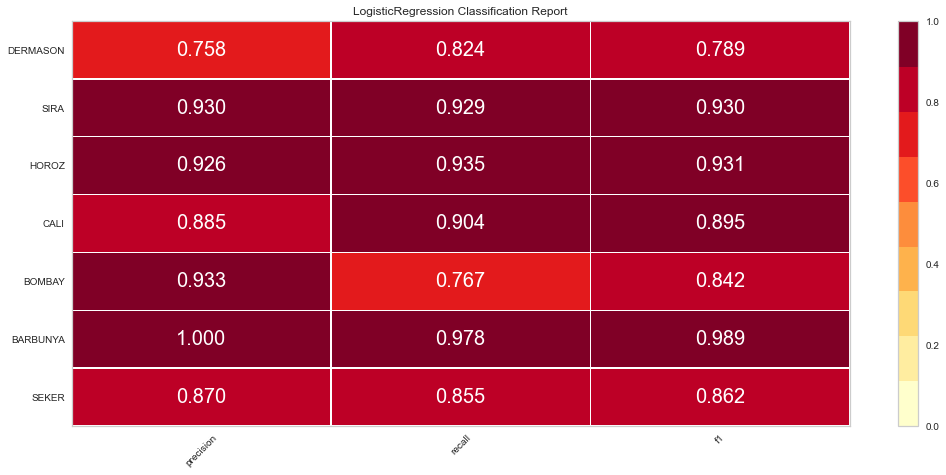

Top 14 features:


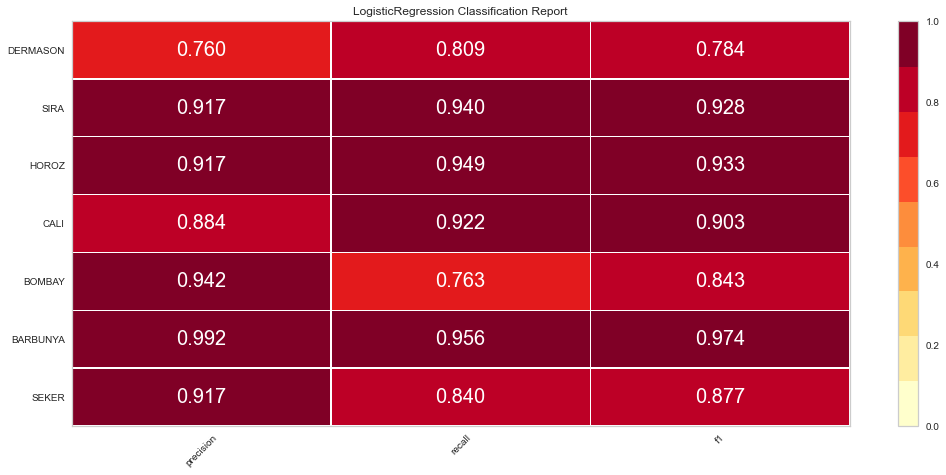

Top 15 features:


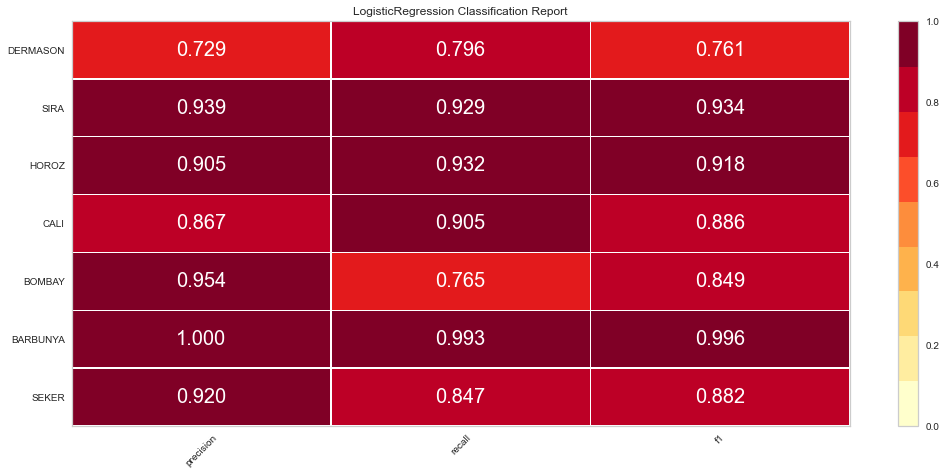

In [135]:
# Set the size of the figure and the font size 
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20
    
for i in np.arange(11, 16):
    feat_list = ranked.Features[:i].tolist() + ['Class']
    df = beanDF[feat_list]
    print(f"Top {i} features:")
    prec_rec_f1(df)

Top 12 features is best:

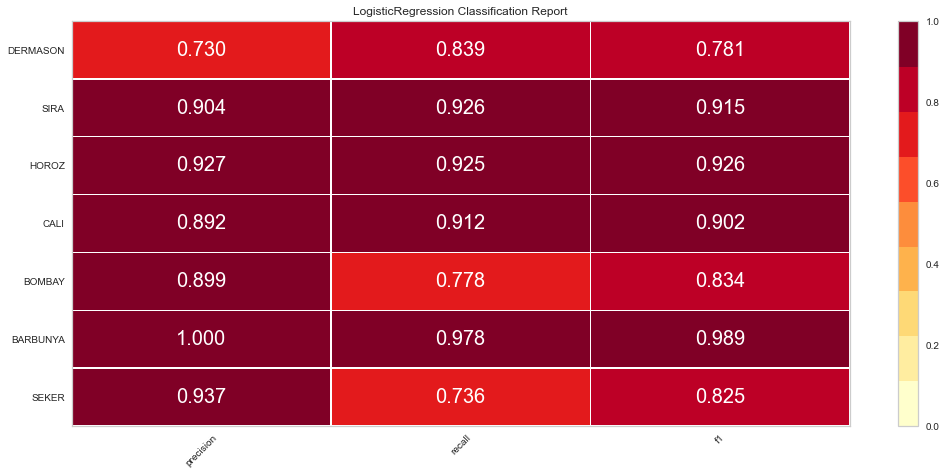

In [136]:
feat_list = ranked.Features[:12].tolist() + ['Class']
bestDF = beanDF[feat_list]
prec_rec_f1(bestDF)

In [137]:
beanDF.Class.value_counts()

DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: Class, dtype: int64

Note: Dermason has the most observations and Bombay the least. I may need to make these proportional to get better data.

## 11.1 Evaluate using cross-validation

In [138]:
# Load libraries
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [139]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

In [140]:
%%time
# Create standardizer
standardizer = StandardScaler()

# Create logistic regression object
logit = LogisticRegression()

# Create a pipeline that standardizes, then runs logistic regression
pipeline = make_pipeline(standardizer, logit)

# Create a k-Fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [141]:
%%time
# Conduct k-fold cross-validation
cv_results = cross_val_score(pipeline, # Pipeline
                             features, # Feature matrix
                             target, # Target vector
                             cv=kf, # Performance metric
                             scoring="accuracy", # Loss function
                             n_jobs=-1) # Use all CPU cores

In [142]:
# Calculate mean
cv_results.mean()

0.923957830954824

In [143]:
# View score for all 10 folds
cv_results

array([0.9339207 , 0.91991183, 0.91917708, 0.91697281, 0.92505511,
       0.9331374 , 0.92872888, 0.92505511, 0.92064658, 0.91697281])

When we `fit` our standardization object, `standardizer`, we calculate the mean and variance of only the training set. Then we apply that tranformation (using `transform`) to both the training and test sets:

In [144]:
# Create training and test sets
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)

# Fit standardizer to training set
standardizer.fit(features_train)

# Apply to both training and test sets
features_train_std = standardizer.transform(features_train)
features_test_std = standardizer.transform(features_test)

In [145]:
%%time
# Create a pipeline to preprocess the data
pipeline = make_pipeline(standardizer, logit)

# Do k-fold cross-validation (KFCV) using that pipeline
cv_results = cross_val_score(pipeline, # Pipeline
                             features, # Feature matrix
                             target, # Target vector
                             cv=kf, # Performance metric
                             scoring="accuracy", # Loss function
                             n_jobs=-1) # Use all CPU cores

In [146]:
# Calculate mean
cv_results.mean()

0.923957830954824

In [147]:
cv_results

array([0.9339207 , 0.91991183, 0.91917708, 0.91697281, 0.92505511,
       0.9331374 , 0.92872888, 0.92505511, 0.92064658, 0.91697281])

Same? CV didn't change so why would it be different

## 11.2 Baseline Classification Model

In [148]:
# Load libraries
from sklearn.datasets import load_iris
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

In [149]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

In [150]:
# Split into training and test set
features_train, features_test, target_train, target_test = train_test_split(
    features, target, random_state=0)

In [151]:
%%time
# Create dummy classifier
dummy = DummyClassifier(strategy='uniform', random_state=1)

# "Train" model
dummy.fit(features_train, target_train)

# Get accuracy score
dummy.score(features_test, target_test)

0.14810461357625623

#### Compare baseline to trained classifier

In [152]:
# Load library
from sklearn.ensemble import RandomForestClassifier

In [153]:
%%time
# Create classifier
classifier = RandomForestClassifier()

# Train model
classifier.fit(features_train, target_train)

# Get accuracy score
classifier.score(features_test, target_test)

0.9288862768145754

## Come back to this later:

## 11.6 Evaluating Muilticlass Classifier Predictions
Use cross-validation with an evaluation metric capable of handling more than two classes:  
Note: only works if there are balanced classes (equal numbers)

In [154]:
# Load libraries
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

In [155]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

In [156]:
# # Create logistic regression
# logit = LogisticRegression()

# # Cross-validate model using accuracy
# cross_val_score(logit, features, target, scoring='accuracy')

In [157]:
# # Cross-validate model using macro averaged F1 score
# cross_val_score(logit, features, target, scoring='f1_macro')

## 11.8 Evaluating Regression Models
Use Mean Squared Error (MSE):

In [158]:
# Load libraries
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [159]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

In [160]:
# # Create a linear regression object
# ols = LinearRegression()

# # Cross-validate the linear regression using (negative) MSE
# cross_val_score(ols, features, target, scoring='neg_mean_squared_error')

## 11.9 Evaluating Clustering Models  
=Nope=  
One option to evaluate clustering is to use silhouette cefficients, which measure the quality of the clusters:

In [161]:
# Load libraries
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [162]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

In [163]:
%%time
# Cluster data using k-means to predict classes
model = KMeans(n_clusters=2, random_state=1).fit(features)

# Get predicted classes
target_predicted = model.labels_

# Evaluate model
silhouette_score(features, target_predicted)

Wall time: 3.64 s


0.6254002946299253

That's pretty low.

## 11.11 Visualizing the Effect of Training Set Size
Plot the learning curve:

In [164]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve

In [165]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

Wall time: 2 ms


In [166]:
%%time
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(# Classifier
                                                        RandomForestClassifier(),
                                                        # Feature matrix
                                                        features,
                                                        # Target vector
                                                        target,
                                                        # Number of folds
                                                        cv=10,
                                                        # Performance metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1,
                                                        # Sizes of 50
                                                        # training set
                                                       train_sizes=np.linspace(
                                                       0.01,
                                                       1.0,
                                                       50))

Wall time: 3min 2s


In [167]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

Wall time: 0 ns


In [168]:
# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

Wall time: 0 ns


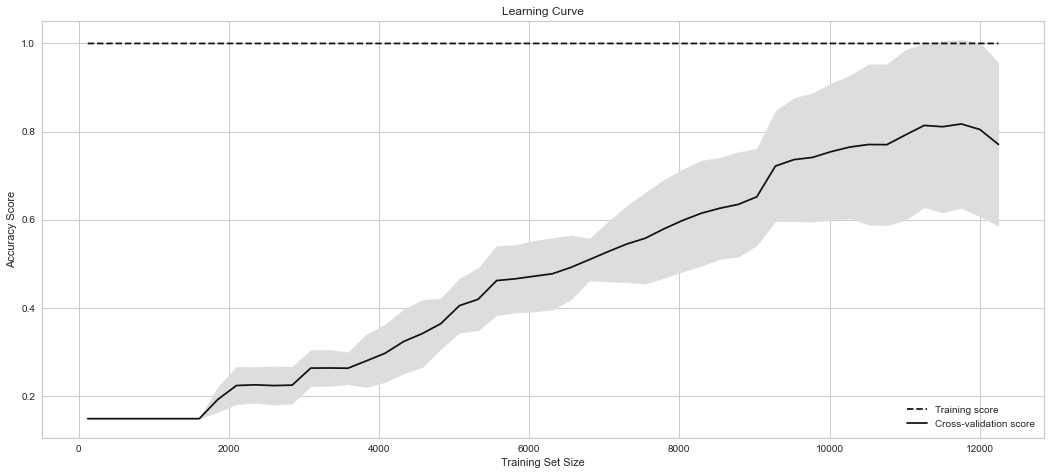

Wall time: 256 ms


In [169]:
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"),
plt.legend(loc="best")
plt.tight_layout()
plt.show()

Note the accuracy continues to increase as we add ovservations. This model may benefit from additional data.

## Ch 12

In [170]:
import warnings
warnings.filterwarnings('ignore')

## 12.1 Selecting Best Models Using Exhaustive Search

In [171]:
# Load libraries
import numpy as np
from sklearn import linear_model, datasets
from sklearn.model_selection import GridSearchCV

In [172]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

In [173]:
%%time
# Create logistic regression
logistic = linear_model.LogisticRegression()

# Create range of candidate penalty hyperparameter values
penalty = ['l1', 'l2']

# Create range of candidate regularization hyperparameter values
C = np.logspace(0, 4, 10)

# Create dictionary hyperparameter candidates
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search
gridsearch = GridSearchCV(logistic, hyperparameters, cv=5, verbose=1)

# Fit grid search
best_model = gridsearch.fit(features, target)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 45.8 s


In [174]:
np.logspace(0,4,10)

array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04])

In [175]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 21.544346900318832


In [176]:
# Predict target vector
best_model.predict(features)

array(['DERMASON', 'SEKER', 'DERMASON', ..., 'SIRA', 'SIRA', 'SIRA'],
      dtype=object)

Let's try to fine-tune 'C' a little more:

In [177]:
np.logspace(0,2,10)

array([  1.        ,   1.66810054,   2.7825594 ,   4.64158883,
         7.74263683,  12.91549665,  21.5443469 ,  35.93813664,
        59.94842503, 100.        ])

In [178]:
%%time
# Create logistic regression
logistic = linear_model.LogisticRegression()

# Create range of candidate penalty hyperparameter values
penalty = ['l1', 'l2']

# Create range of candidate regularization hyperparameter values
C = np.logspace(np.logspace(0,2,10))

# Create dictionary hyperparameter candidates
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search
gridsearch = GridSearchCV(logistic, hyperparameters, cv=5, verbose=1)

# Fit grid search
best_model = gridsearch.fit(features, target)

TypeError: _logspace_dispatcher() missing 1 required positional argument: 'stop'

In [179]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 21.544346900318832


Same result.

In [180]:
best_model.best_estimator_.get_params()

{'C': 21.544346900318832,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

#### Try with original data set:

In [181]:
# Create features matrix
features_cols = beanDF.columns[:-1].tolist()
features = beanDF[features_cols]

# Create target vector
target = beanDF.Class

In [182]:
%%time
# Create logistic regression
logistic = linear_model.LogisticRegression()

# Create range of candidate penalty hyperparameter values
penalty = ['l1', 'l2']

# Create range of candidate regularization hyperparameter values
C = np.logspace(0, 4, 10)

# Create dictionary hyperparameter candidates
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search
gridsearch = GridSearchCV(logistic, hyperparameters, cv=5, verbose=1)

# Fit grid search
best_model = gridsearch.fit(features, target)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 46.8 s


In [183]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 1.0


In [184]:
best_model.best_score_

0.6293592045122468

Well that's worse.

## 12.3 Selecting Best Models from Multiple Learning Algorithms

In [185]:
# Load libraries
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [186]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

In [187]:
%%time
# Create a pipeline
pipe = Pipeline([("classifier", RandomForestClassifier())])

# Create dictionary with candidate learning algorithms and their hyperparameters
search_space = [{"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l1', 'l2'],
                 "classifier__C": np.logspace(0, 4, 10)},
                {"classifier": [RandomForestClassifier()],
                 "classifier__n_estimators": [10, 100, 1000],
                 "classifier__max_features": [1, 2, 3]}]

# Create grid search
gridsearch = GridSearchCV(pipe, search_space, cv=5, verbose=1)

# Fit grid search
best_model = gridsearch.fit(features, target)

Fitting 5 folds for each of 29 candidates, totalling 145 fits
Wall time: 6min 33s


In [188]:
# View best model
best_model.best_estimator_.get_params()["classifier"]

LogisticRegression(C=21.544346900318832)

In [189]:
best_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('classifier', LogisticRegression(C=21.544346900318832))],
 'verbose': False,
 'classifier': LogisticRegression(C=21.544346900318832),
 'classifier__C': 21.544346900318832,
 'classifier__class_weight': None,
 'classifier__dual': False,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__l1_ratio': None,
 'classifier__max_iter': 100,
 'classifier__multi_class': 'auto',
 'classifier__n_jobs': None,
 'classifier__penalty': 'l2',
 'classifier__random_state': None,
 'classifier__solver': 'lbfgs',
 'classifier__tol': 0.0001,
 'classifier__verbose': 0,
 'classifier__warm_start': False}

In [190]:
# Predict target vector
best_model.predict(features)

array(['DERMASON', 'SEKER', 'DERMASON', ..., 'SIRA', 'SIRA', 'SIRA'],
      dtype=object)

In [198]:
# Calculate percent correct using best model
num_correct = np.count_nonzero(best_model.predict(features) == bestDF.Class)
num_total = bestDF.Class.count()
num_correct / num_total * 100

85.25457350672251

## 12.4 Selecting Best Models When Preprocessing

In [199]:
# Load libraries
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [200]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

In [201]:
# Create a preprocessing object that includes StandardScaler features and PCA
preprocess = FeatureUnion([("std", StandardScaler()), ("pca", PCA())])

# Create a pipeline
pipe = Pipeline([("preprocess", preprocess),
                 ("classifier", LogisticRegression())])

# Create space of candidate values
search_space = [{"preprocess__pca__n_components": [1, 2, 3],
                 "classifier__penalty": ["l1", "l2"],
                 "classifier__C": np.logspace(0, 4, 10)}]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=5, verbose=0, n_jobs=-1)

Wall time: 0 ns


In [202]:
%%time
# Fit grid search
best_model = clf.fit(features, target)

Wall time: 43.1 s


In [203]:
# View best model
best_model.best_estimator_.get_params()['preprocess__pca__n_components']

2

In [204]:
best_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('preprocess',
   FeatureUnion(transformer_list=[('std', StandardScaler()),
                                  ('pca', PCA(n_components=2))])),
  ('classifier', LogisticRegression(C=464.15888336127773))],
 'verbose': False,
 'preprocess': FeatureUnion(transformer_list=[('std', StandardScaler()),
                                ('pca', PCA(n_components=2))]),
 'classifier': LogisticRegression(C=464.15888336127773),
 'preprocess__n_jobs': None,
 'preprocess__transformer_list': [('std', StandardScaler()),
  ('pca', PCA(n_components=2))],
 'preprocess__transformer_weights': None,
 'preprocess__verbose': False,
 'preprocess__std': StandardScaler(),
 'preprocess__pca': PCA(n_components=2),
 'preprocess__std__copy': True,
 'preprocess__std__with_mean': True,
 'preprocess__std__with_std': True,
 'preprocess__pca__copy': True,
 'preprocess__pca__iterated_power': 'auto',
 'preprocess__pca__n_components': 2,
 'preprocess__pca__random_state': None,
 'preprocess__pca__svd

#### PCA: See section 9.1 Reducing Features Using Principal Components

In [205]:
# Load libraries
import numpy as np
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [206]:
# Create features matrix
features_cols = beanDF.columns[:-1].tolist()
features = beanDF[features_cols]

# Create target vector
target = beanDF.Class

In [207]:
# Create a preprocessing object that includes StandardScaler features and PCA
preprocess = FeatureUnion([("std", StandardScaler()), ("pca", PCA())])

# Create a pipeline
pipe = Pipeline([("preprocess", preprocess),
                 ("classifier", LogisticRegression())])

# Create space of candidate values
search_space = [{"preprocess__pca__n_components": [1, 2, 3],
                 "classifier__penalty": ["l1", "l2"],
                 "classifier__C": np.logspace(0, 4, 10)}]

# Create grid search
clf = GridSearchCV(pipe, search_space, cv=5, verbose=0, n_jobs=-1)

In [208]:
%%time
# Fit grid search
best_model = clf.fit(features, target)

Wall time: 38.6 s


In [209]:
# View best model
best_model.best_estimator_.get_params()['preprocess__pca__n_components']

1

In [210]:
best_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('preprocess',
   FeatureUnion(transformer_list=[('std', StandardScaler()),
                                  ('pca', PCA(n_components=1))])),
  ('classifier', LogisticRegression(C=21.544346900318832))],
 'verbose': False,
 'preprocess': FeatureUnion(transformer_list=[('std', StandardScaler()),
                                ('pca', PCA(n_components=1))]),
 'classifier': LogisticRegression(C=21.544346900318832),
 'preprocess__n_jobs': None,
 'preprocess__transformer_list': [('std', StandardScaler()),
  ('pca', PCA(n_components=1))],
 'preprocess__transformer_weights': None,
 'preprocess__verbose': False,
 'preprocess__std': StandardScaler(),
 'preprocess__pca': PCA(n_components=1),
 'preprocess__std__copy': True,
 'preprocess__std__with_mean': True,
 'preprocess__std__with_std': True,
 'preprocess__pca__copy': True,
 'preprocess__pca__iterated_power': 'auto',
 'preprocess__pca__n_components': 1,
 'preprocess__pca__random_state': None,
 'preprocess__pca__svd

## 12.6 Speeding Up Model Selection Using Algorithm-Specific Methods

In [211]:
# Load libraries
from sklearn import linear_model, datasets

In [212]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

In [213]:
# Create cross-validated logistic regression
logit = linear_model.LogisticRegressionCV(Cs=100)

In [214]:
%%time
# Train model
logit.fit(features, target)

Wall time: 6min 23s


LogisticRegressionCV(Cs=100)

## 12.7 Evaluating Performance After Model Selection

In [215]:
# Load libraries
import numpy as np
from sklearn import linear_model, datasets
from sklearn.model_selection import GridSearchCV, cross_val_score

In [216]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

In [217]:
# Create logistic regression
logistic = linear_model.LogisticRegression()

# Create range of 20 candidate values for C
C = np.logspace(0, 4, 20)

# Create hyperparameter options
hyperparameters = dict(C=C)

# Create grid search
gridsearch = GridSearchCV(logistic, hyperparameters, cv=5, n_jobs=-1, verbose=0)

Wall time: 0 ns


In [218]:
%%time
# Conduct nested cross-validation and output the average score
cross_val_score(gridsearch, features, target).mean()

Wall time: 1min 31s


0.7978212375974871

In [219]:
gridsearch = GridSearchCV(logistic, hyperparameters, cv=5, verbose=1)

Wall time: 0 ns


In [220]:
%%time
best_model = gridsearch.fit(features, target)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 1min 20s


In [221]:
%%time
scores = cross_val_score(gridsearch, features, target)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Wall time: 5min 40s


## 16.2 Training a Multiclass Classifier

In [231]:
# Load libraries
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

In [232]:
# Create features matrix
features_cols = bestDF.columns[:-1].tolist()
features = bestDF[features_cols]

# Create target vector
target = bestDF.Class

In [233]:
%%time
# Standardize features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Create one-vs-rest logistic regression object
logistic_regression = LogisticRegression(random_state=0, multi_class="ovr")

# Train model
model = logistic_regression.fit(features_standardized, target)

Wall time: 703 ms


In [234]:
# Create range of 20 candidate values for C
C = np.logspace(0, 4, 20)

# Create hyperparameter options
hyperparameters = dict(C=C)

# Create grid search
gridsearch = GridSearchCV(logistic_regression, hyperparameters, cv=5, n_jobs=-1, verbose=0)

In [235]:
%%time
# Conduct nested cross-validation and output the average score
cross_val_score(gridsearch, features, target).mean()

Wall time: 1min 37s


0.8297085296477092

Can use `'multinomial'` for multi_class= instead of `'ovr'`

In [236]:
%%time
# Standardize features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Create one-vs-rest logistic regression object
logistic_regression = LogisticRegression(random_state=0, multi_class='multinomial')

# Train model
model = logistic_regression.fit(features_standardized, target)

Wall time: 965 ms


In [237]:
# Create range of 20 candidate values for C
C = np.logspace(0, 4, 20)

# Create hyperparameter options
hyperparameters = dict(C=C)

# Create grid search
gridsearch = GridSearchCV(logistic_regression, hyperparameters, cv=5, n_jobs=-1, verbose=0)

In [238]:
%%time
# Conduct nested cross-validation and output the average score
cross_val_score(gridsearch, features, target).mean()

Wall time: 1min 28s


0.7978212375974871

Looks like 'ovr' is better than 'multinomial' in this case.